# Introduction
This Notebook researches what a good model is for predicting solar radiation based on the features specified in the dataset.
This notebook compares many different models, Bayesian and Non-Bayesian to eventually find the model which has the highest accuracy amongst them.

This notebook will first import most functions necessary, after which helper functions will be specified.
After the helper functions, preprocessing will be done.
Once the data is ready, the different models will be tested.

In [1]:
# Clears entire notebook
%reset -f

showInfo = True;
showPredictionPlots = True;
showModelParamPlots = True;

amountOfSamplesForPlot = 500;

testSize = 0.10
dayLightCorrection = True;

chronologicalOrder = False;


# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn import preprocessing

# Packages for linear group
from CompEx1Models import *
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn_rvm import EMRVR

# Packages for tree group
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Packages for neural group
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from keras.optimizers import Adam

# Packages for the remainder models group
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor


# Package for nicely printing the metrics
from tabulate import tabulate

# Helper functions

In [3]:
# Helper function for calculating all necessary metrics at once
def calcMetrics(YTrue, YPredict):
    MAE = mean_absolute_error(YTrue, YPredict);
    MSE = mean_squared_error(YTrue, YPredict);
    R2Score = r2_score(YTrue, YPredict);
    EVS = mean_absolute_percentage_error(YTrue, YPredict);
    MaxE = max_error(YTrue, YPredict);

    return [MAE, MSE, R2Score, EVS, MaxE]

In [4]:
# Helper function for printing all metrics at once for a single regressor
def printTestMetrics(YTrue, YPredict):
    tableLabels = ['Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'MAPE', 'Max Error'];
    tableValues = calcMetrics(YTrue, YPredict)
    
    print(tabulate([tableLabels, tableValues],headers='firstrow', tablefmt='fancy_grid'))

In [5]:
# Helper function to plot both prediction and groundtruth of a single regressor
def plotPrediction(YTrue, YPredict):
    plt.figure(figsize=(30,5))
    plt.plot(np.arange(0,len(YTrue)), YTrue, label='True values')
    plt.plot(np.arange(0,len(YTrue)), YPredict, label='Predictions')
    plt.legend()

In [6]:
# Generates the contents of a latex table for easy `copy pasting' to the report
def generateTex(table):
    outputTable = "";
    
    for i in range(1,len(table)):
        outputTable += "  \\\\ \hline \n ";
        outputTable += str(table[i][0]);
        for j in range(1, len(table[0])):
            outputTable += " & " + str(round(table[i][j], 2)) 
    outputTable += "  \\\\ \hline \n ";
    print(outputTable)

# Import Data

In [7]:
data = pd.read_csv(('./SolarPrediction.csv'))

if (showInfo):
    data.info()
    data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## Clean data

In [8]:
if showInfo:
    data.isnull().sum()

### Make separate columns of object types

In [9]:
# Make date of each element three columns and drop the Data object
data['Year'] = pd.DatetimeIndex(data['Data']).year
data['Month'] = pd.DatetimeIndex(data['Data']).month
data['Day'] = pd.DatetimeIndex(data['Data']).day
data.drop('Data', axis = 1, inplace=True)

# Make time of each element three columns and drop the Time object
data['Hour'] = pd.DatetimeIndex(data['Time']).hour
data['Minute'] = pd.DatetimeIndex(data['Time']).minute
data['Second'] = pd.DatetimeIndex(data['Time']).second
data.drop('Time', axis = 1, inplace=True)

# Make time of each element three columns and drop the TimeSunRise object
data['SunRiseHour'] = pd.DatetimeIndex(data['TimeSunRise']).hour
data['SunRiseMinute'] = pd.DatetimeIndex(data['TimeSunRise']).minute
data['SunRiseSecond'] = pd.DatetimeIndex(data['TimeSunRise']).second
data.drop('TimeSunRise', axis = 1, inplace=True)

# Make time of each element three columns and drop the TimeSunSet object
data['SunSetHour'] = pd.DatetimeIndex(data['TimeSunSet']).hour
data['SunSetMinute'] = pd.DatetimeIndex(data['TimeSunSet']).minute
data['SunSetSecond'] = pd.DatetimeIndex(data['TimeSunSet']).second
data.drop('TimeSunSet', axis = 1, inplace=True)

if (showInfo):
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Radiation               32686 non-null  float64
 2   Temperature             32686 non-null  int64  
 3   Pressure                32686 non-null  float64
 4   Humidity                32686 non-null  int64  
 5   WindDirection(Degrees)  32686 non-null  float64
 6   Speed                   32686 non-null  float64
 7   Year                    32686 non-null  int64  
 8   Month                   32686 non-null  int64  
 9   Day                     32686 non-null  int64  
 10  Hour                    32686 non-null  int64  
 11  Minute                  32686 non-null  int64  
 12  Second                  32686 non-null  int64  
 13  SunRiseHour             32686 non-null  int64  
 14  SunRiseMinute           32686 non-null

Plot the correlations between the features

<Axes: >

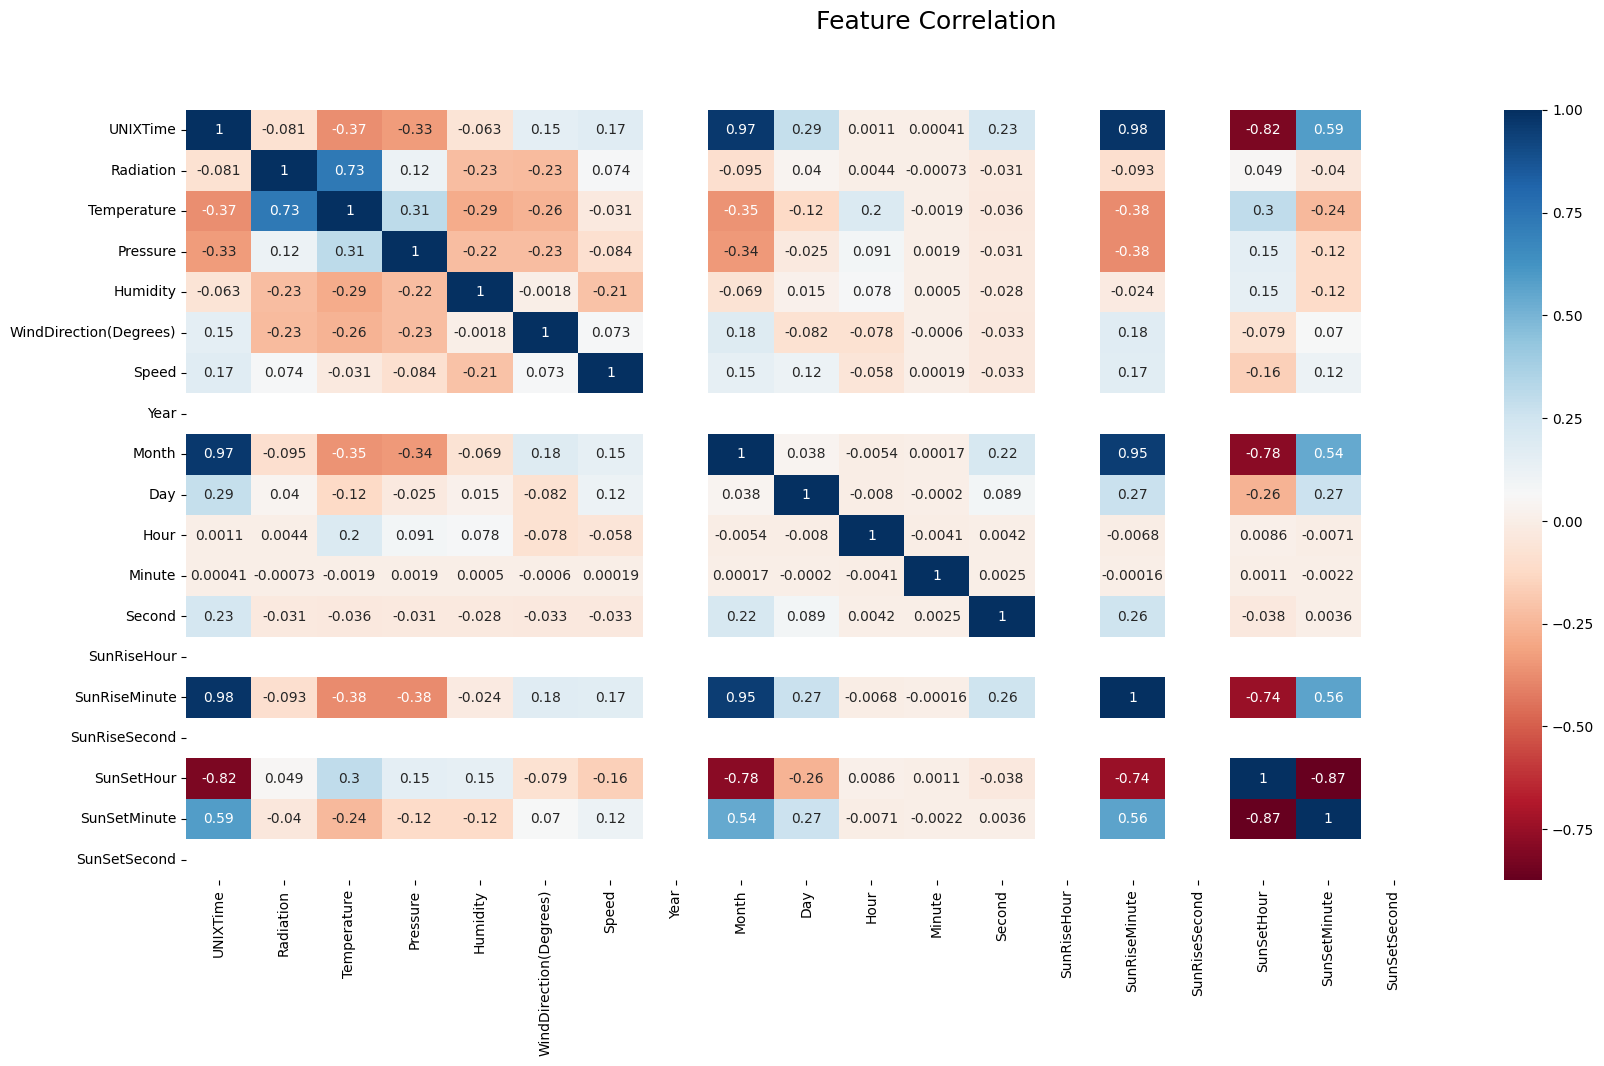

In [10]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Feature Correlation', fontsize=18)
seaborn.heatmap(data.corr(), annot=True, cmap='RdBu')

In [11]:
# Used to show there are still NaN in the correlation matrix
if showInfo:
    data.corr()

In [12]:
if showInfo:
    data.describe()
# Recognise that Year, SunRiseHour, SunRiseSecond, SunSetSecond have a standard deviation of 0 and are thus the same throughout the dataset
# Therefore we can drop these variables as they contain no information in regards to the radiation

In [13]:
# As these column do not hold any information (they always have the same value), these will be removed from the dataset
data.drop('Year', axis = 1, inplace=True)
data.drop('SunRiseHour', axis = 1, inplace=True)
data.drop('SunRiseSecond', axis = 1, inplace=True)
data.drop('SunSetSecond', axis = 1, inplace=True)

<Axes: >

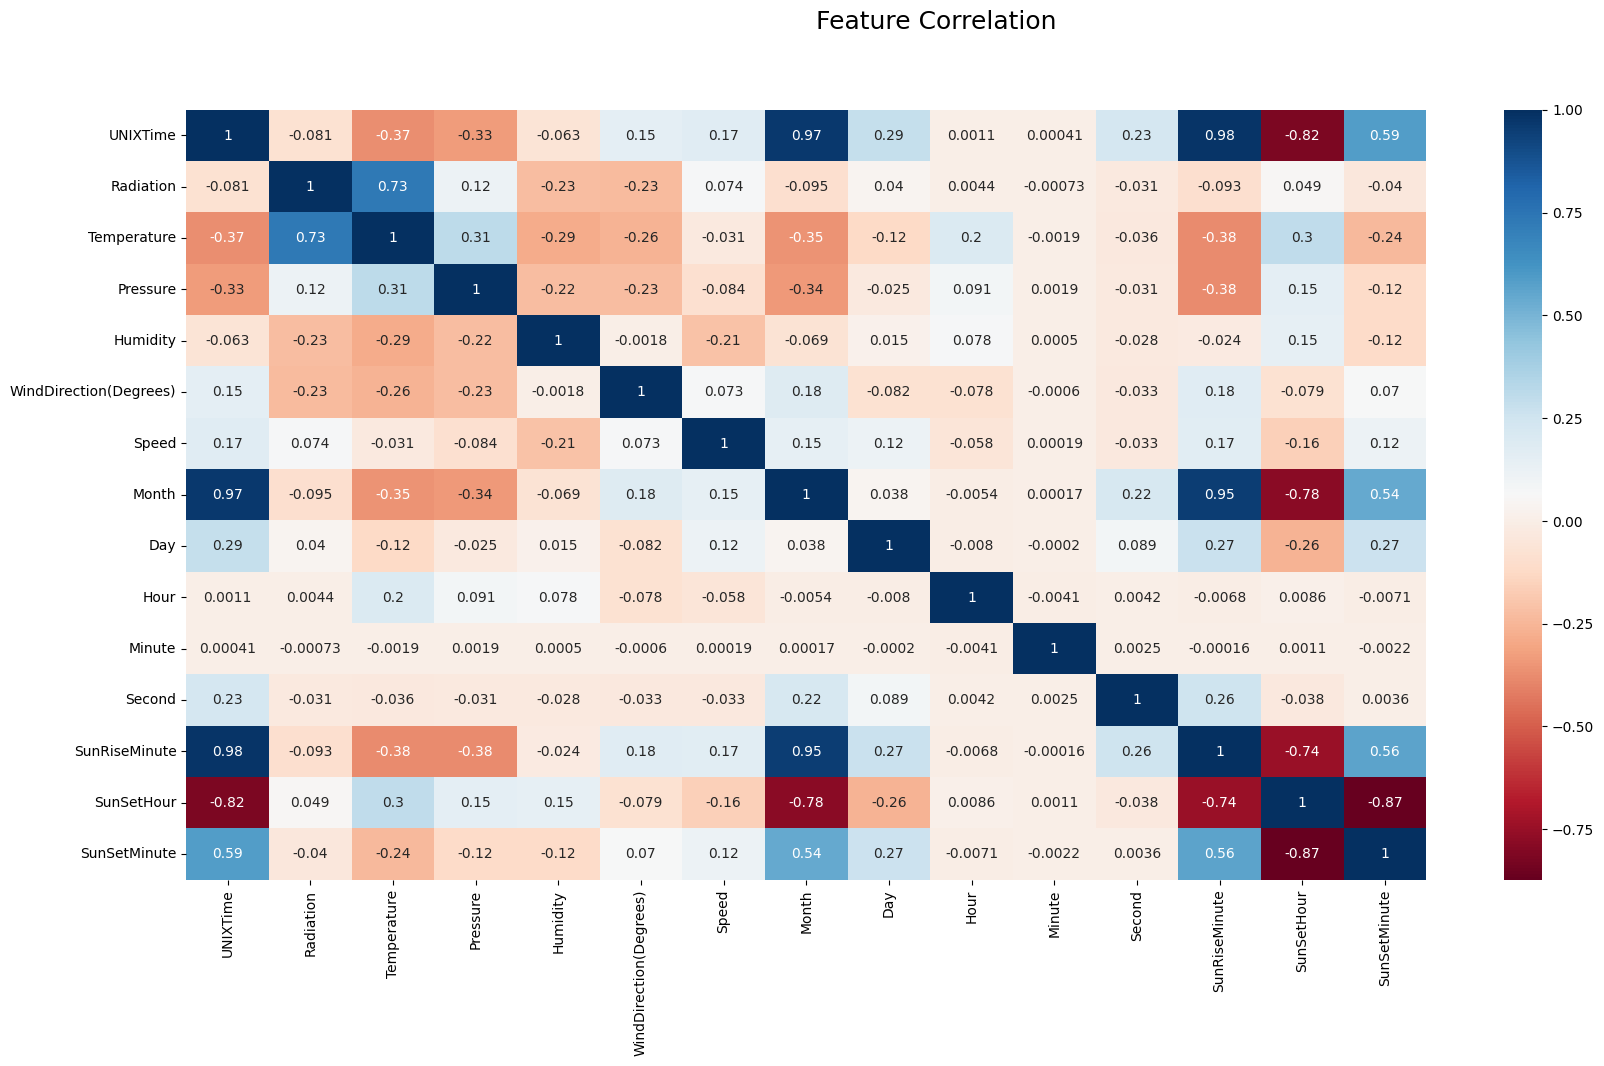

In [14]:
# show correlation matrix after feature removal
fig = plt.figure(figsize=(20,10))
fig.suptitle('Feature Correlation', fontsize=18)
seaborn.heatmap(data.corr(), annot=True, cmap='RdBu')

## Daylight correction

The whole dataset consist of samples taken during the day and samples taken during the night. Since we interested in prediction solar radiation (radiation from the sun), it may be better to only use the samples taken during the night, and state that once it is nighttime there is no radiation. This may lead to a model which is better suited as it will fit better to these daylight samples.

In [15]:
SamplesBeforeDayLightCorrection = data.shape[0]


if dayLightCorrection:
    data = data[data.Hour > 5]
    data = data[data.Hour < 19]

SamplesAfterDayLightCorrection = data.shape[0]

data = data.sort_values(by=['UNIXTime'], ascending=True)

# Train test split

In [16]:
features = data.iloc[:,data.columns != 'Radiation' ]
radiation = data.iloc[:, data.columns == 'Radiation']

if showInfo:
    features.info()
    radiation.info()


Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, radiation, test_size = testSize, shuffle=not(chronologicalOrder))

scalerX = preprocessing.StandardScaler().fit(Xtrain)
scalerY = preprocessing.StandardScaler().fit(Ytrain)

XtrainScaled = scalerX.transform(Xtrain)
XtrainScaled = np.pad(XtrainScaled ,[(0,0),(0,1)], mode='constant' ,constant_values=(1))

YtrainScaled = scalerY.transform(Ytrain)

XtestScaled = scalerX.transform(Xtest)
XtestScaled = np.pad(XtestScaled ,[(0,0),(0,1)], mode='constant' ,constant_values=(1))

YtestScaled = scalerY.transform(Ytest)

# To make sure the tests can be compared, the predictions will be zero-pad as well as their respetive ground truth. This means that the assumption is made that the models predict 0 radiation during night time.
padLength = int((SamplesBeforeDayLightCorrection-SamplesAfterDayLightCorrection)*testSize)
Ytest = np.pad(Ytest, [(0, padLength), (0,0)], 'constant', constant_values=0);

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17665 entries, 7351 to 24582
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                17665 non-null  int64  
 1   Temperature             17665 non-null  int64  
 2   Pressure                17665 non-null  float64
 3   Humidity                17665 non-null  int64  
 4   WindDirection(Degrees)  17665 non-null  float64
 5   Speed                   17665 non-null  float64
 6   Month                   17665 non-null  int64  
 7   Day                     17665 non-null  int64  
 8   Hour                    17665 non-null  int64  
 9   Minute                  17665 non-null  int64  
 10  Second                  17665 non-null  int64  
 11  SunRiseMinute           17665 non-null  int64  
 12  SunSetHour              17665 non-null  int64  
 13  SunSetMinute            17665 non-null  int64  
dtypes: float64(3), int64(11)
memory usa

# Modellen
## Linear Models
### Linear Regression

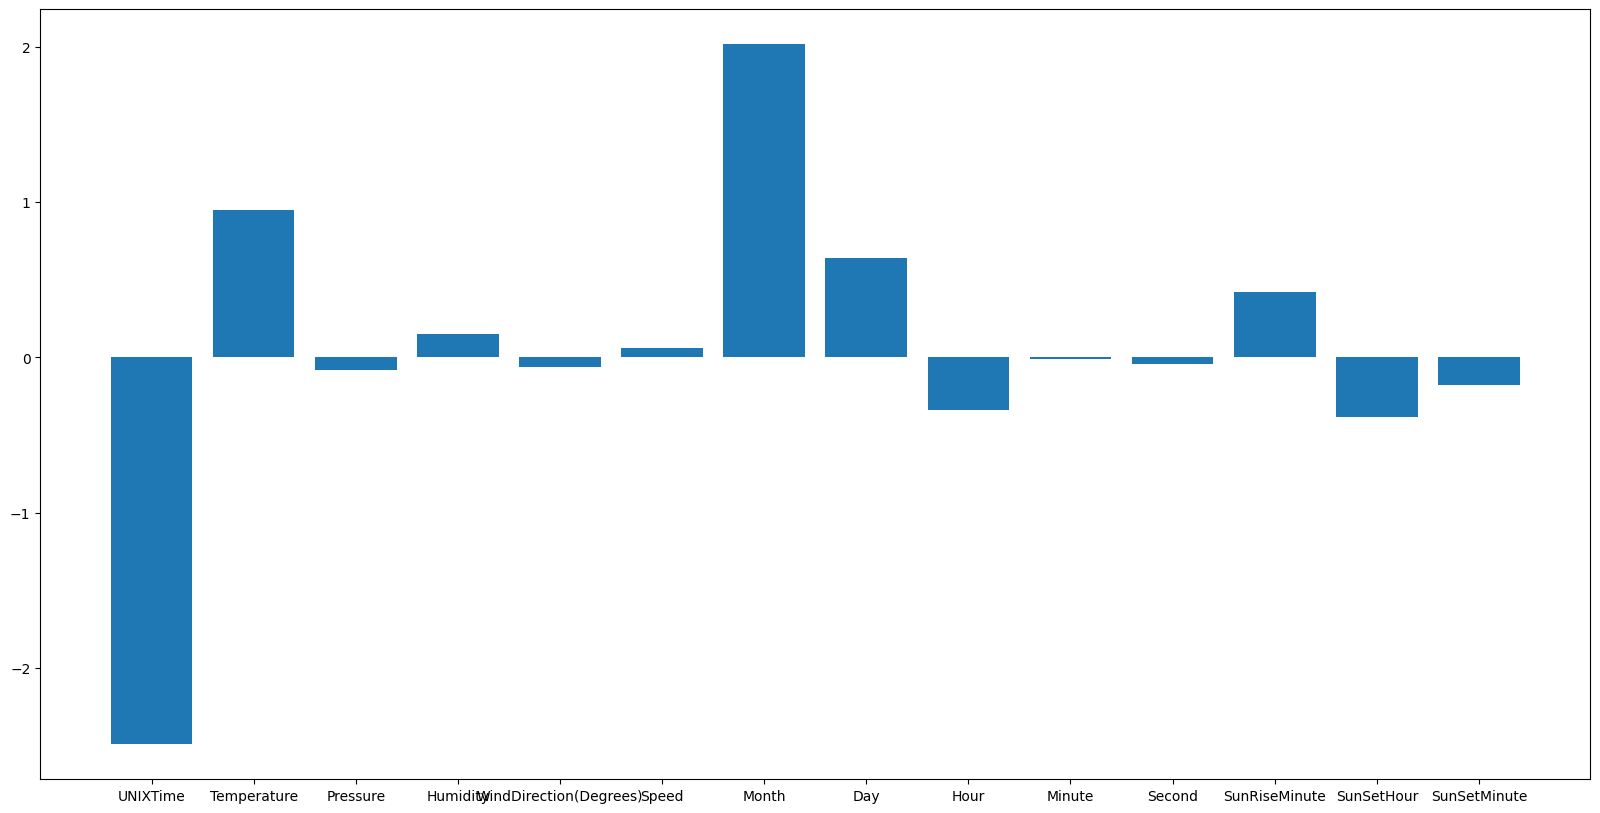

In [17]:
linRegModel = LinearRegression();
linRegModel.fit(XtrainScaled, YtrainScaled); 

if (showModelParamPlots):
    plt.figure(figsize=(20,10))
    plt.bar(features.columns, linRegModel.coef_[0][0:14])

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               96.0409 │              26613.9 │   0.738249 │ 6.45257 │     975.686 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


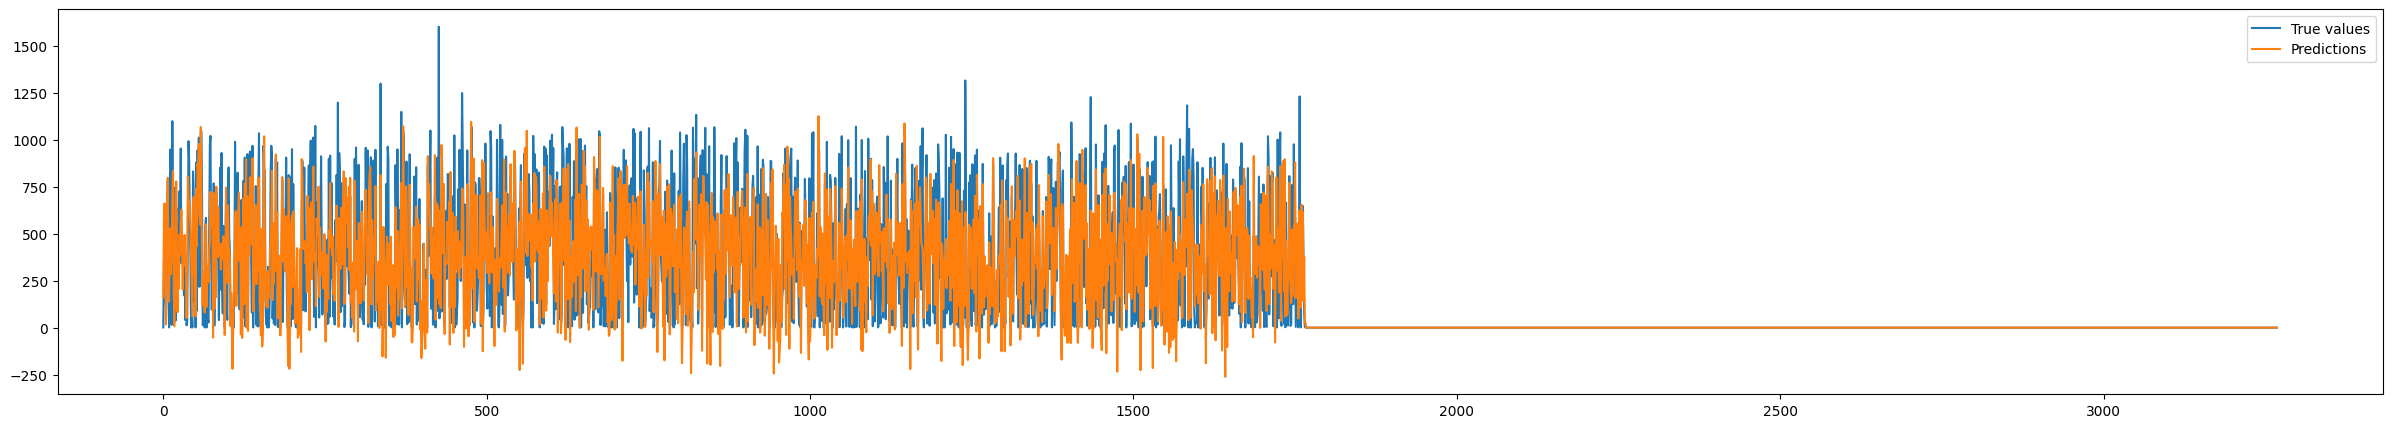

In [18]:
linRegRadiationPredictions = scalerY.inverse_transform(linRegModel.predict(XtestScaled));
linRegRadiationPredictions = np.pad(linRegRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, linRegRadiationPredictions)

if showPredictionPlots:
    plotPrediction(Ytest, linRegRadiationPredictions)

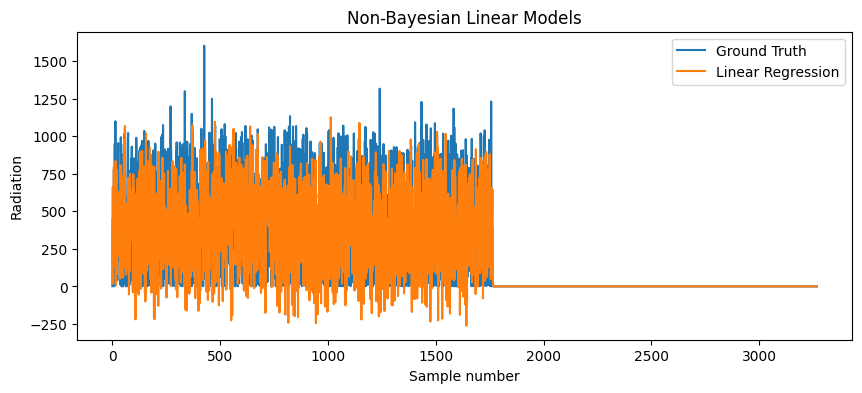

In [19]:
timeAxis = Xtest['UNIXTime'][0:100]

if showPredictionPlots:
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(0, len(Ytest)), Ytest, label="Ground Truth")
    plt.plot(np.arange(0, len(Ytest)), linRegRadiationPredictions, label="Linear Regression",)
    plt.legend(loc="upper right")
    # np.arange(0, len(Ytest))
    plt.title("Non-Bayesian Linear Models")
    plt.xlabel("Sample number")
    plt.ylabel("Radiation")

### Ridge Regression

In [20]:
ridgeModel = Ridge();

ridgeModel.fit(XtrainScaled, YtrainScaled)

ridgeRadiationPredictions = scalerY.inverse_transform(ridgeModel.predict(XtestScaled))
ridgeRadiationPredictions = np.pad(ridgeRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, ridgeRadiationPredictions);

╒═══════════════════════╤══════════════════════╤════════════╤════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │   MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪════════╪═════════════╡
│               96.1235 │              26636.6 │   0.738026 │ 6.4749 │     977.698 │
╘═══════════════════════╧══════════════════════╧════════════╧════════╧═════════════╛


### Bayesian Regression

In [21]:
bRegModel = BayesianRegression(alpha=1, beta=1);
bRegModel.fit(XtrainScaled, np.ravel(YtrainScaled))

predBReg, stdBReg = bRegModel.predict(XtestScaled, return_std=True)
predBReg = (scalerY.inverse_transform(predBReg.reshape(-1,1)))
stdBReg = (scalerY.inverse_transform(stdBReg.reshape(-1,1)))
# predBReg = predBReg.reshape(-1,1)
# stdBReg = stdBReg.reshape(-1,1)

predBReg = np.pad(predBReg, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, predBReg)

╒═══════════════════════╤══════════════════════╤════════════╤════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │   MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪════════╪═════════════╡
│               96.1235 │              26636.6 │   0.738026 │ 6.4749 │     977.698 │
╘═══════════════════════╧══════════════════════╧════════════╧════════╧═════════════╛


### Empirical Bayesian Regressian

In [22]:
bEmpRegModel = EmpiricalBayesRegression(alpha=1., beta=1.);
bEmpRegModel.fit(XtrainScaled, np.ravel(YtrainScaled))


predBEmpReg, stdBEmpReg = bEmpRegModel.predict(XtestScaled, return_std=True)
print(stdBEmpReg.mean())
predBEmpReg = (scalerY.inverse_transform(predBEmpReg.reshape(-1,1)))
stdBEmpReg = (scalerY.inverse_transform(stdBEmpReg.reshape(-1,1)));


predBEmpReg = np.pad(predBEmpReg, [(0, padLength), (0,0)], 'constant', constant_values=0);
printTestMetrics(Ytest, predBEmpReg)

0.6336825838044208
╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               96.1399 │              26637.3 │   0.738019 │ 6.47581 │     978.498 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


### EM

In [23]:
EMModel = EM(alpha=1., beta=1.);
EMModel.fit(XtrainScaled, np.ravel(YtrainScaled))

predEM, stdEM = EMModel.predict(XtestScaled, return_std=True)
predEM = (scalerY.inverse_transform(predEM.reshape(-1,1)))
stdEM = (scalerY.inverse_transform(stdEM.reshape(-1,1)));

predEM = np.pad(predEM, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, predEM)

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│                 96.14 │              26637.2 │   0.738019 │ 6.47578 │     978.508 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


### VB

In [24]:
VBModel = VB(alpha=1., beta=1.);
VBModel.fit(XtrainScaled, np.ravel(YtrainScaled))

predVB, stdVB = VBModel.predict(XtestScaled, return_std=True)
predVB = (scalerY.inverse_transform(predVB.reshape(-1,1)))
stdVB = (scalerY.inverse_transform(stdVB.reshape(-1,1)));

predVB = np.pad(predVB, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, predVB)

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               96.1443 │              26636.7 │   0.738024 │ 6.46581 │     979.745 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


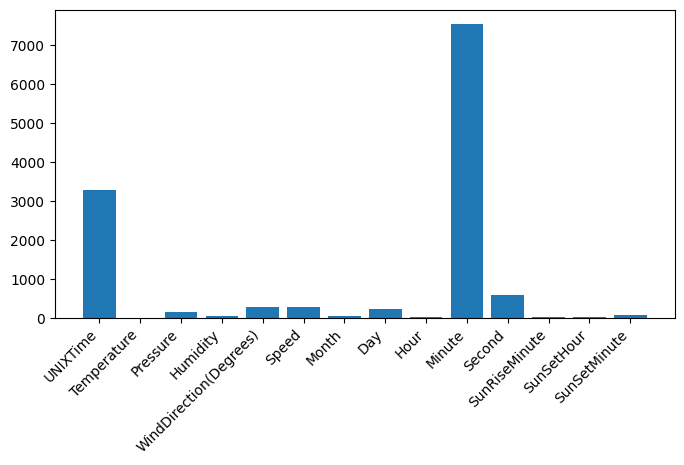

In [25]:
if showModelParamPlots:
    plt.figure(figsize=(8,4))
    plt.bar(Xtrain.columns,VBModel.alpha[0:14])
    plt.xticks(rotation=45,ha='right');

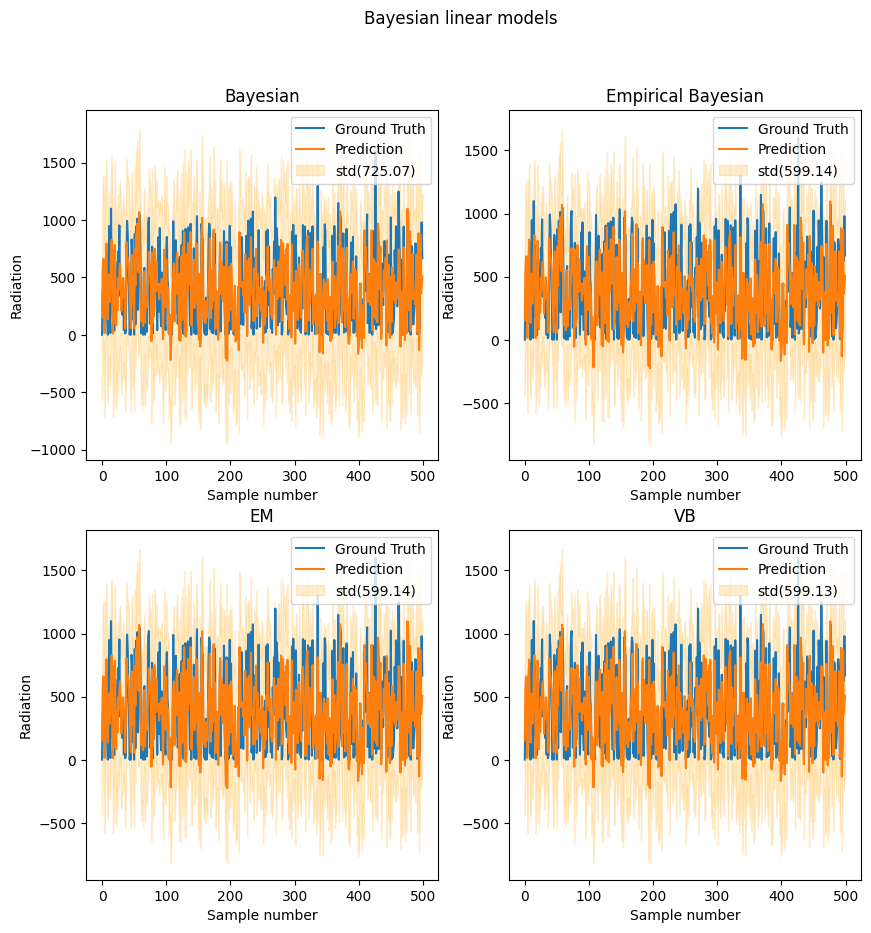

In [26]:
## PLOTJES
if showPredictionPlots:
    timeAxis = Xtest['UNIXTime'][0:amountOfSamplesForPlot]
    timeAxis = np.arange(0, len(Ytest))[0:amountOfSamplesForPlot]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
    ax1.plot(timeAxis, np.array(Ytest[0:amountOfSamplesForPlot]), label = "Ground Truth")
    ax1.plot(timeAxis, predBReg[0:amountOfSamplesForPlot], label="Prediction")
    ax1.fill_between(timeAxis, np.ravel(predBReg[0:amountOfSamplesForPlot]-stdBReg[0:amountOfSamplesForPlot]), np.ravel(predBReg[0:amountOfSamplesForPlot]+stdBReg[0:amountOfSamplesForPlot]), alpha = 0.2, label = f"std({round(stdBReg.mean(), 2)})", color='orange')
    ax1.legend(loc="upper right")
    ax1.set_title("Bayesian")
    ax1.set_xlabel("Sample number")
    ax1.set_ylabel("Radiation")

    ax2.plot(timeAxis, np.array(Ytest[0:amountOfSamplesForPlot]), label = "Ground Truth")
    ax2.plot(timeAxis, predBEmpReg[0:amountOfSamplesForPlot], label="Prediction")
    ax2.fill_between(timeAxis, np.ravel(predBEmpReg[0:amountOfSamplesForPlot]-stdBEmpReg[0:amountOfSamplesForPlot]), np.ravel(predBEmpReg[0:amountOfSamplesForPlot]+stdBEmpReg[0:amountOfSamplesForPlot]), alpha = 0.2, label = f"std({round(stdBEmpReg.mean(),2)})", color='orange')
    ax2.legend(loc="upper right")
    ax2.set_title("Empirical Bayesian")
    ax2.set_xlabel("Sample number")
    ax2.set_ylabel("Radiation")

    ax3.plot(timeAxis, np.array(Ytest[0:amountOfSamplesForPlot]), label = "Ground Truth")
    ax3.plot(timeAxis, predEM[0:amountOfSamplesForPlot], label = "Prediction")
    ax3.fill_between(timeAxis, np.ravel(predEM[0:amountOfSamplesForPlot]-stdEM[0:amountOfSamplesForPlot]), np.ravel(predEM[0:amountOfSamplesForPlot]+stdEM[0:amountOfSamplesForPlot]), alpha = 0.2, label = f"std({round(stdEM.mean(),2)})", color='orange')
    ax3.legend(loc="upper right")
    ax3.set_title("EM")
    ax3.set_xlabel("Sample number")
    ax3.set_ylabel("Radiation")

    ax4.plot(timeAxis, np.array(Ytest[0:amountOfSamplesForPlot]), label = "Ground Truth")
    ax4.plot(timeAxis, predVB[0:amountOfSamplesForPlot], label="Prediction")
    ax4.fill_between(timeAxis, np.ravel(predVB[0:amountOfSamplesForPlot]-stdVB[0:amountOfSamplesForPlot]), np.ravel(predVB[0:amountOfSamplesForPlot]+stdVB[0:amountOfSamplesForPlot]), alpha = 0.2, label=f"std({round(stdVB.mean(), 2)})", color='orange')
    ax4.legend(loc="upper right")
    ax4.set_title("VB")
    ax4.set_xlabel("Sample number")
    ax4.set_ylabel("Radiation")

    fig.suptitle("Bayesian linear models")



### Bayesian Ridge

In [27]:
bRidgeModel = BayesianRidge();

bRidgeModel.fit(XtrainScaled, YtrainScaled)

bRidgeRadiationPredictions = scalerY.inverse_transform(bRidgeModel.predict(XtestScaled).reshape(-1,1))
bRidgeRadiationPredictions = np.pad(bRidgeRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, bRidgeRadiationPredictions);

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               96.1392 │              26637.4 │   0.738018 │ 6.47591 │      978.45 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


C:\Users\Tycho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Lasso

In [28]:
lassoModel = Lasso(alpha=.1);

lassoModel.fit(XtrainScaled, YtrainScaled)

lassoRadiationPredictions = scalerY.inverse_transform(lassoModel.predict(XtestScaled).reshape(-1,1))
lassoRadiationPredictions = np.pad(lassoRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, lassoRadiationPredictions);

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               108.897 │              32428.8 │   0.681059 │ 8.60591 │     1014.29 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


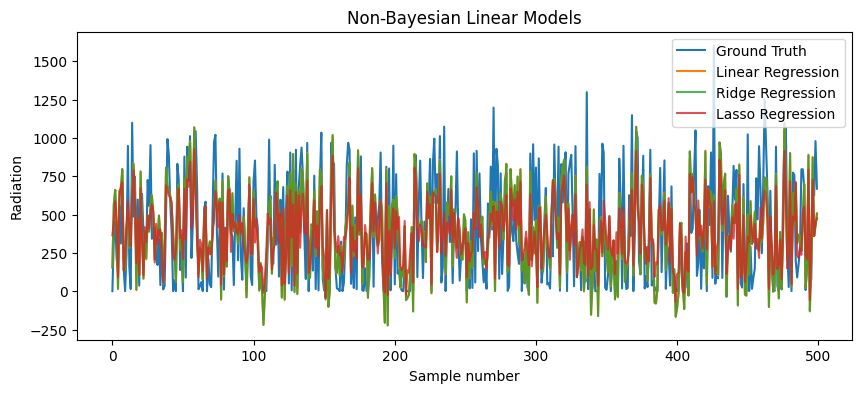

In [29]:
if showPredictionPlots:
    plt.figure(figsize=(10,4))

    plt.plot(np.arange(0, len(Ytest))[0:500], Ytest[0:500], label="Ground Truth")
    plt.plot(np.arange(0, len(Ytest))[0:500], linRegRadiationPredictions[0:500], label="Linear Regression", alpha = 1)
    plt.plot(np.arange(0, len(Ytest))[0:500], ridgeRadiationPredictions[0:500], label="Ridge Regression", alpha = 0.8)
    plt.plot(np.arange(0, len(Ytest))[0:500], lassoRadiationPredictions[0:500], label="Lasso Regression", alpha = 0.8)
    
    plt.legend(loc="upper right")
    plt.title("Non-Bayesian Linear Models")
    plt.xlabel("Sample number")
    plt.ylabel("Radiation")

## Tree based models

### Decision Tree


╒═══════════════════════╤══════════════════════╤════════════╤══════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │     MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪══════════╪═════════════╡
│               37.4685 │                10096 │   0.900705 │ 0.406181 │     942.617 │
╘═══════════════════════╧══════════════════════╧════════════╧══════════╧═════════════╛


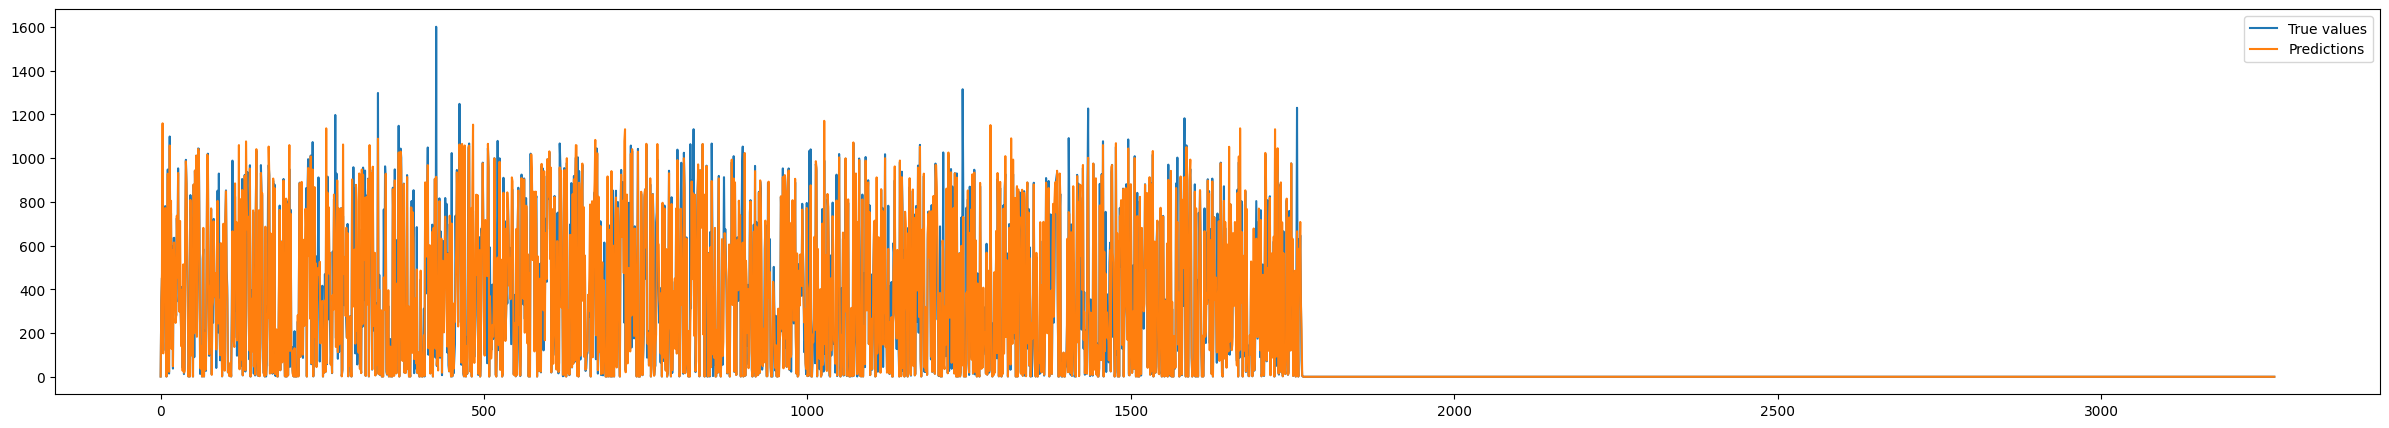

In [30]:
decTreeModel = DecisionTreeRegressor(min_samples_leaf=3,min_samples_split=6,max_depth=30,max_features=0.7);
decTreeModel.fit(XtrainScaled, YtrainScaled);


decTreeRadiationPredictions = scalerY.inverse_transform(decTreeModel.predict(XtestScaled).reshape(-1,1))
decTreeRadiationPredictions = np.pad(decTreeRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, decTreeRadiationPredictions)
plotPrediction(Ytest, decTreeRadiationPredictions)

### Random Forest

╒═══════════════════════╤══════════════════════╤════════════╤══════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │     MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪══════════╪═════════════╡
│               30.3322 │              6315.15 │    0.93789 │ 0.186947 │     889.644 │
╘═══════════════════════╧══════════════════════╧════════════╧══════════╧═════════════╛


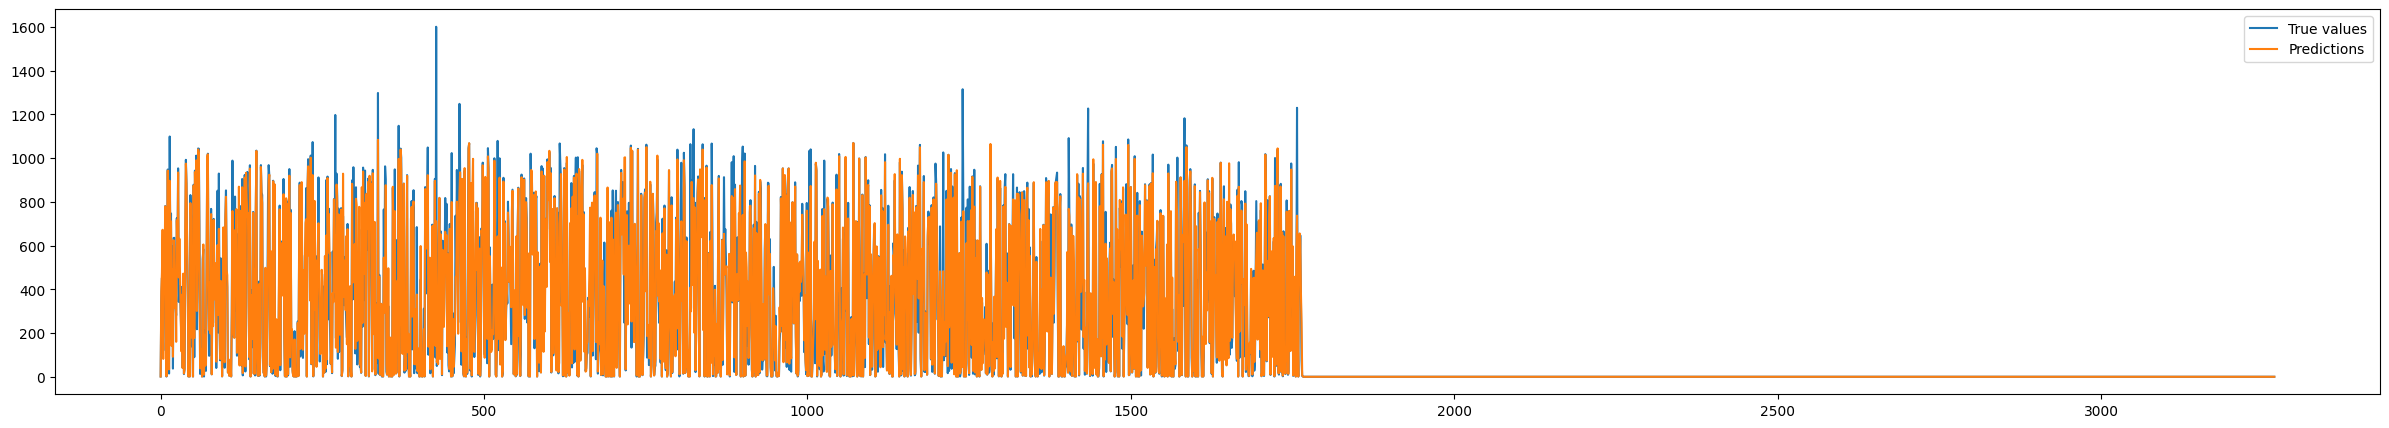

In [31]:
rndForestModel = RandomForestRegressor(min_samples_leaf=3,min_samples_split=6,max_depth=30,max_features=0.7);
rndForestModel.fit(XtrainScaled, np.ravel(YtrainScaled))


rndForestRadiationPredictions = scalerY.inverse_transform(rndForestModel.predict(XtestScaled).reshape(-1,1));
rndForestRadiationPredictions = np.pad(rndForestRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, rndForestRadiationPredictions)
plotPrediction(Ytest, rndForestRadiationPredictions)

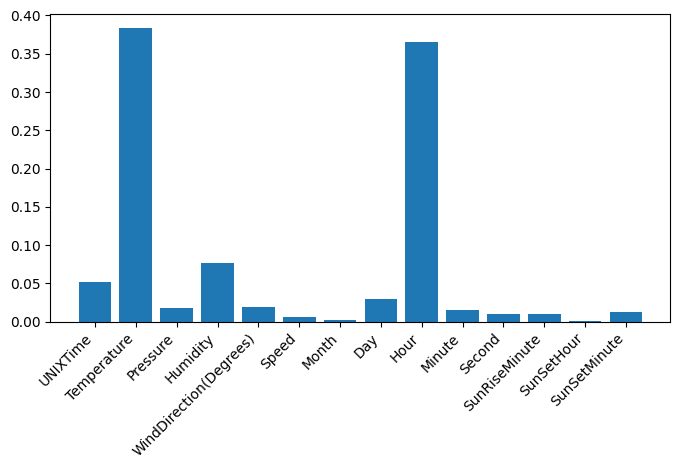

In [32]:
if showModelParamPlots:
    plt.figure(figsize=(8,4))
    plt.bar(Xtrain.columns, rndForestModel.feature_importances_[0:14])
    plt.xticks(rotation=45,ha='right');

### Extra trees

╒═══════════════════════╤══════════════════════╤════════════╤══════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │     MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪══════════╪═════════════╡
│               30.5618 │              6365.86 │   0.937391 │ 0.226249 │     907.292 │
╘═══════════════════════╧══════════════════════╧════════════╧══════════╧═════════════╛


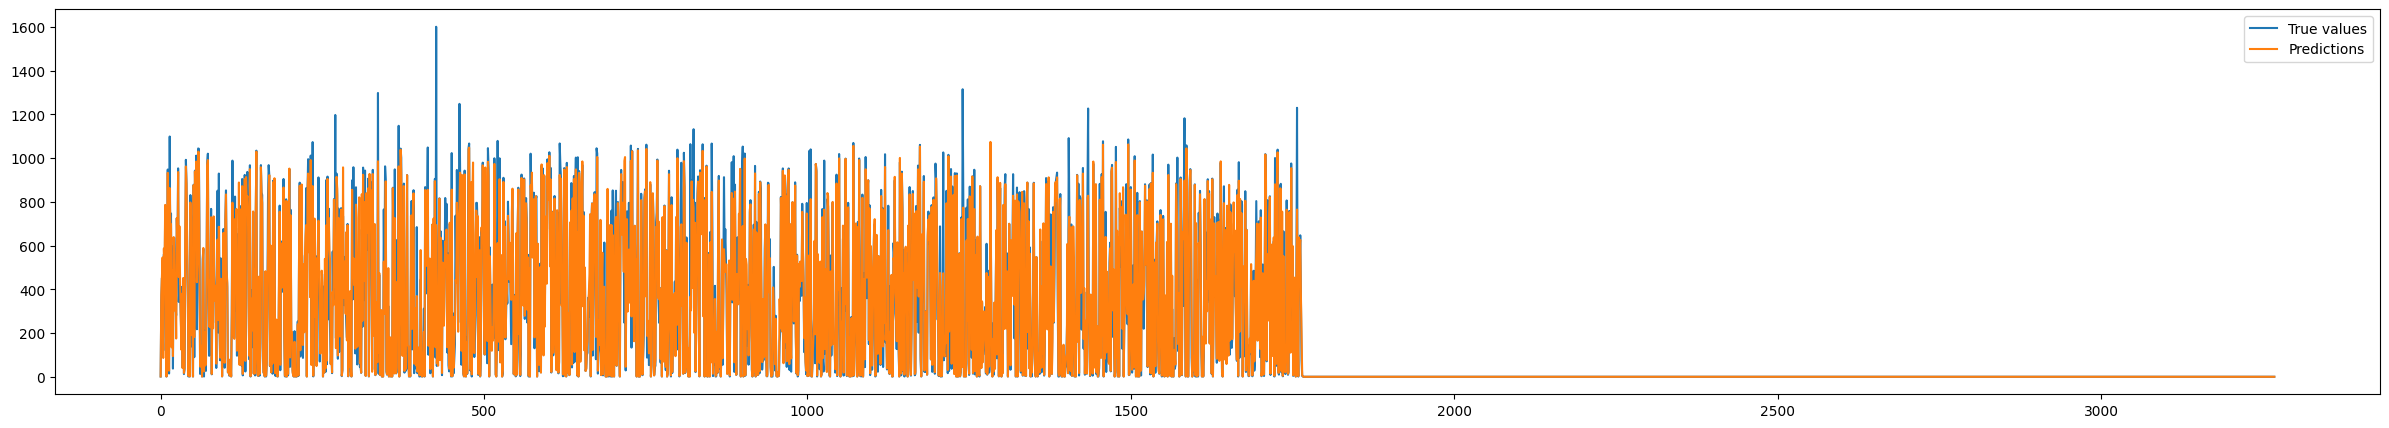

In [33]:
xTreeModel = ExtraTreesRegressor(min_samples_leaf=3,min_samples_split=6,max_depth=30,max_features=0.7);
xTreeModel.fit(XtrainScaled, np.ravel(YtrainScaled))


xTreeRadiationPredictions = scalerY.inverse_transform(xTreeModel.predict(XtestScaled).reshape(-1,1));
xTreeRadiationPredictions = np.pad(xTreeRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, xTreeRadiationPredictions)

if showPredictionPlots:
    plotPrediction(Ytest, xTreeRadiationPredictions)

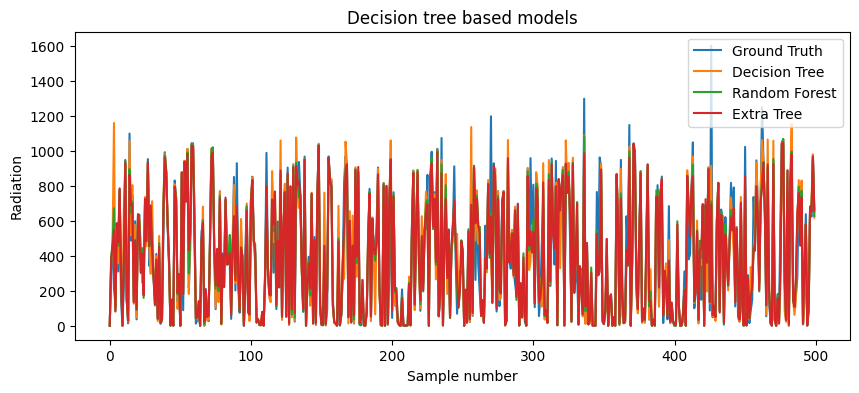

In [34]:
if showPredictionPlots:
    plt.figure(figsize=(10,4))
    plotSamples = 500;
    plt.plot(np.arange(0, len(Ytest))[0:500], Ytest[0:500], label="Ground Truth")
    plt.plot(np.arange(0, len(Ytest))[0:500], decTreeRadiationPredictions[0:500], label="Decision Tree", alpha = 1)
    plt.plot(np.arange(0, len(Ytest))[0:500], rndForestRadiationPredictions[0:500], label="Random Forest", alpha = 1)
    plt.plot(np.arange(0, len(Ytest))[0:500], xTreeRadiationPredictions[0:500], label="Extra Tree", alpha = 1)
    plt.legend(loc="upper right")
    # np.arange(0, len(Ytest))
    plt.title("Decision tree based models")
    plt.xlabel("Sample number")
    plt.ylabel("Radiation")

## Neural network based models

### Neural Network

In [35]:
model = Sequential()
model.add(Dense(256, activation='relu', kernel_initializer='normal', input_shape=(Xtrain.shape[1]+1,), kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'categorical_crossentropy'])




Epoch 1/10


C:\Users\Tycho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


497/497 [==============================] - 4s 5ms/step - loss: 1.3751 - mse: 0.2589 - categorical_crossentropy: 4.3979e-16
Epoch 2/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2951 - mse: 0.1898 - categorical_crossentropy: 1.6805e-16
Epoch 3/10
497/497 [==============================] - 2s 4ms/step - loss: 0.2659 - mse: 0.1837 - categorical_crossentropy: -4.4694e-18
Epoch 4/10
497/497 [==============================] - 2s 3ms/step - loss: 0.2507 - mse: 0.1753 - categorical_crossentropy: 1.4302e-16
Epoch 5/10
497/497 [==============================] - 1s 3ms/step - loss: 0.2486 - mse: 0.1769 - categorical_crossentropy: 1.0727e-16
Epoch 6/10
497/497 [==============================] - 2s 3ms/step - loss: 0.2444 - mse: 0.1745 - categorical_crossentropy: 1.8056e-16
Epoch 7/10
497/497 [==============================] - 1s 3ms/step - loss: 0.2372 - mse: 0.1691 - categorical_crossentropy: 1.0727e-16
Epoch 8/10
497/497 [==============================] - 2s 3ms/step - loss

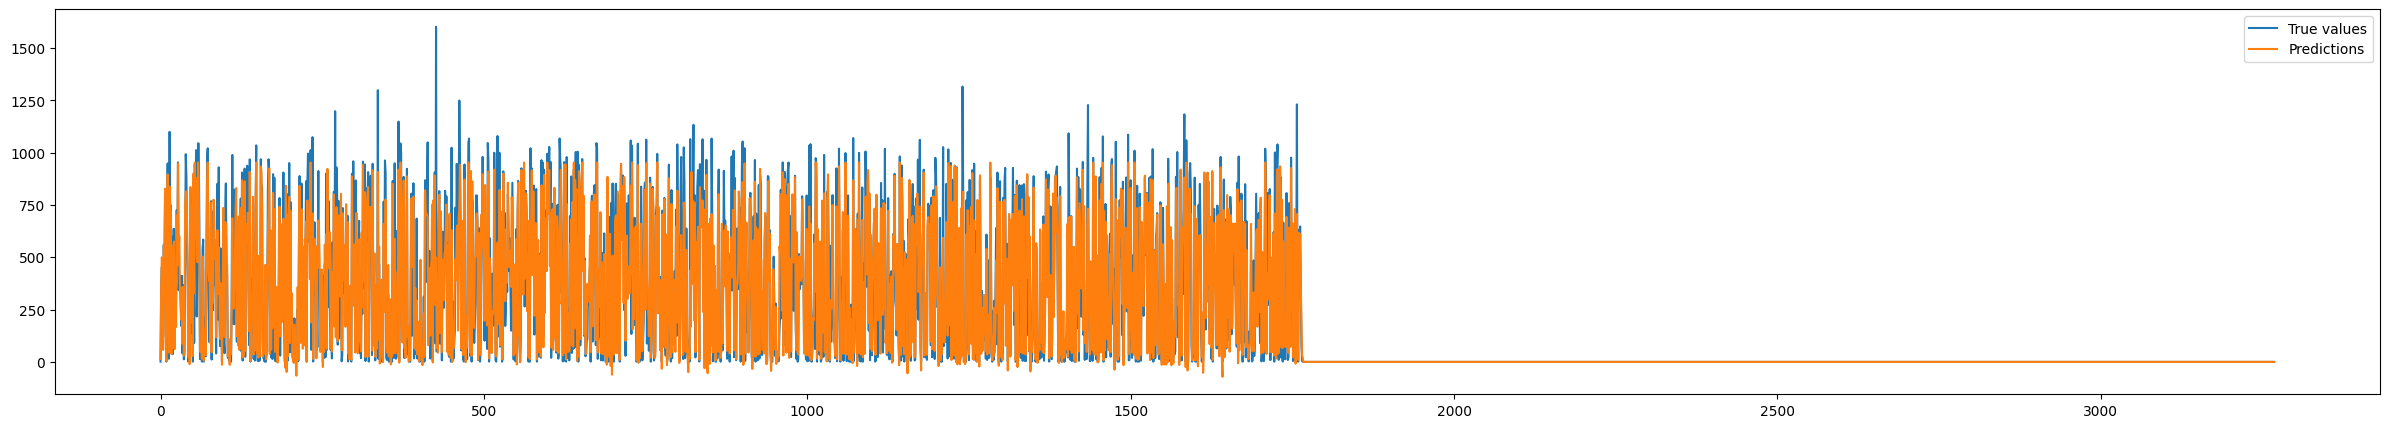

In [36]:
model.fit(XtrainScaled, YtrainScaled, epochs=10)

neuralRadiationPredictions = scalerY.inverse_transform(model.predict(XtestScaled))
neuralRadiationPredictions = np.pad(neuralRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);

printTestMetrics(Ytest, neuralRadiationPredictions)

if showPredictionPlots:
    plotPrediction(Ytest, neuralRadiationPredictions)

### BCNN

In [37]:
dropoutAtInference = True;

inputLayer = Input(shape=(None, Xtrain.shape[1]+1))
intLayer = Dense(256, activation='relu', kernel_initializer='normal', input_shape=(Xtrain.shape[1],), kernel_regularizer=regularizers.l2(l=0.01))(inputLayer)
intLayer = Dropout(0.2)(intLayer, training=dropoutAtInference)
intLayer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(intLayer)
intLayer = Dropout(0.2)(intLayer, training=dropoutAtInference)
intLayer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(intLayer)
intLayer = Dropout(0.2)(intLayer, training=dropoutAtInference)
intLayer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(intLayer)
intLayer = Dropout(0.2)(intLayer, training=dropoutAtInference)
intLayer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l=0.01))(intLayer)
intLayer = Dropout(0.2)(intLayer, training=dropoutAtInference)
outputLayer = Dense(1, activation='linear')(intLayer)

model_mc = keras.Model(inputLayer, outputLayer)
model_mc.compile(loss='mse', optimizer='adam', metrics=['mse'])

model_mc.fit(XtrainScaled, YtrainScaled, epochs=10)


Epoch 1/10
497/497 [==============================] - 4s 5ms/step - loss: 1.5510 - mse: 0.3079
Epoch 2/10
497/497 [==============================] - 3s 5ms/step - loss: 0.3424 - mse: 0.2353
Epoch 3/10
497/497 [==============================] - 2s 5ms/step - loss: 0.3116 - mse: 0.2204
Epoch 4/10
497/497 [==============================] - 2s 5ms/step - loss: 0.3135 - mse: 0.2263
Epoch 5/10
497/497 [==============================] - 2s 5ms/step - loss: 0.3007 - mse: 0.2161
Epoch 6/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2992 - mse: 0.2167
Epoch 7/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2992 - mse: 0.2174
Epoch 8/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2959 - mse: 0.2155
Epoch 9/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2894 - mse: 0.2097
Epoch 10/10
497/497 [==============================] - 2s 5ms/step - loss: 0.2903 - mse: 0.2118


56/56 [==============================] - 0s 3ms/step
╒═══════════════════════╤══════════════════════╤════════════╤════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │   MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪════════╪═════════════╡
│               57.5641 │              12792.2 │   0.874187 │ 2.6133 │      1002.5 │
╘═══════════════════════╧══════════════════════╧════════════╧════════╧═════════════╛


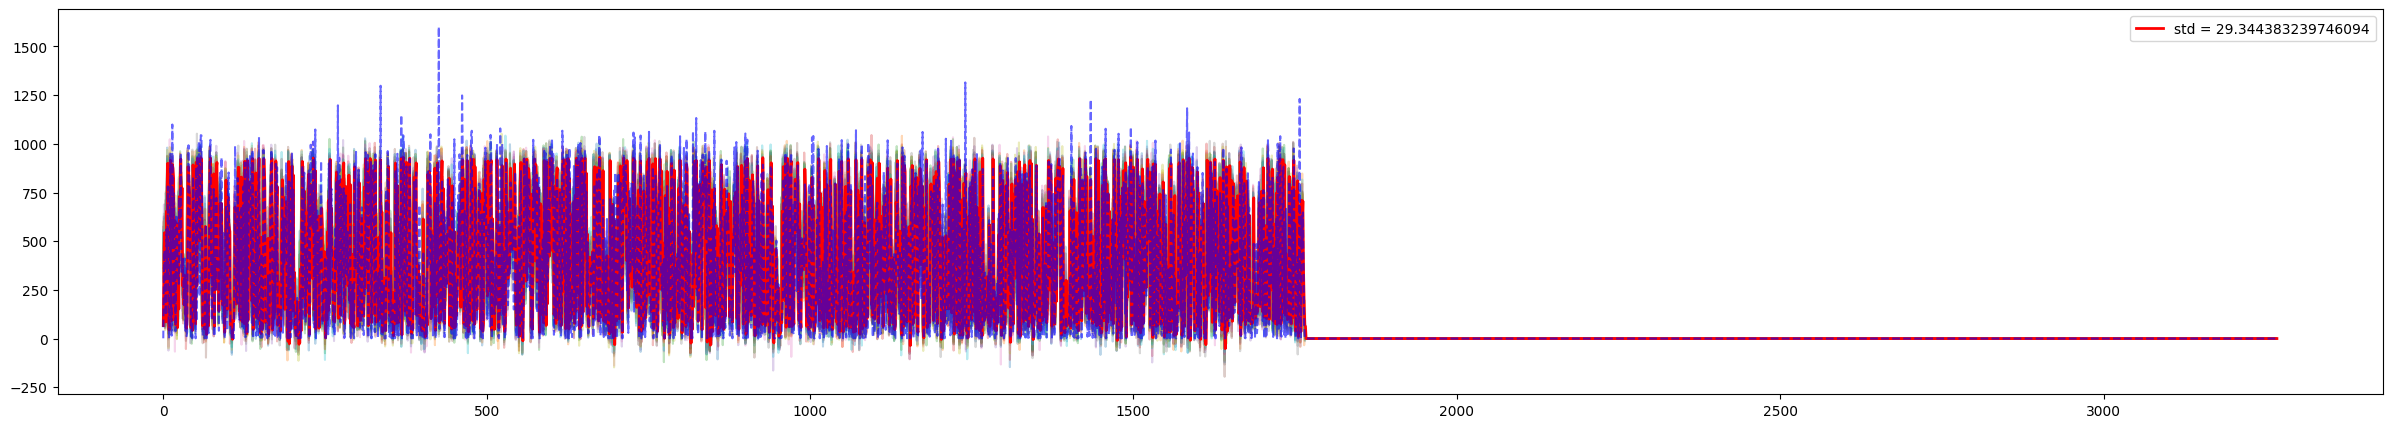

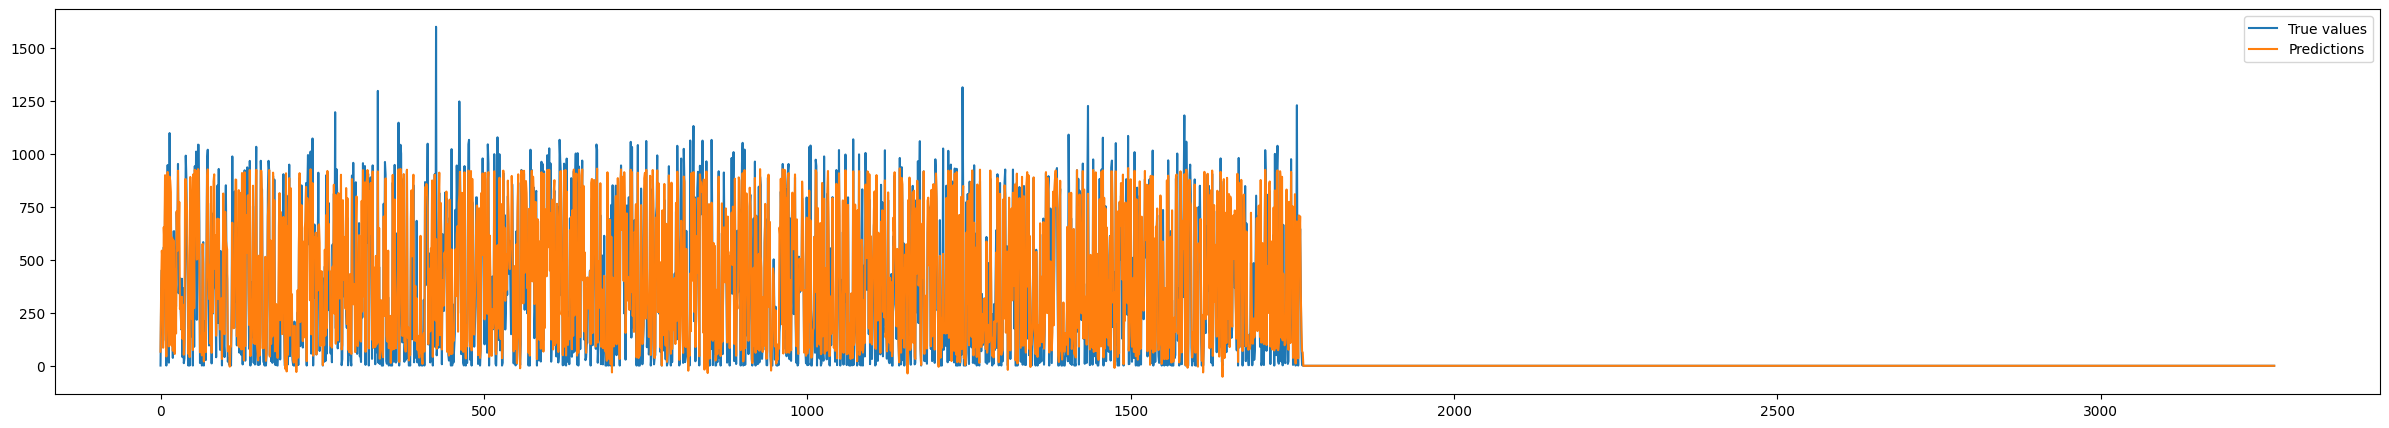

In [38]:
# predict for 100 times and take the mean
predictiones = []
for i in range(100):
    curPrediction = scalerY.inverse_transform(model_mc.predict(XtestScaled));
    curPrediction = np.pad(curPrediction, [(0, padLength), (0,0)], 'constant', constant_values=0);

    predictiones.append(curPrediction)




BneuralRadiationPredictions = np.mean(predictiones, axis=0)
Bneuralstd = np.std(predictiones, axis=0)

if showPredictionPlots:
    plt.figure(figsize=(30,5))
    for i in range(20):
        plt.plot(predictiones[i][1:-1], alpha=0.3)
    plt.plot(BneuralRadiationPredictions, linewidth = 2, color='red', label = f"std = {np.mean(np.std(predictiones, axis=(0)))}")
    plt.plot(np.arange(0,len(Ytest)), Ytest, color='blue', linestyle='dashed', alpha = 0.6)
    plt.legend()

printTestMetrics(Ytest, BneuralRadiationPredictions)

if showPredictionPlots:
    plotPrediction(Ytest, BneuralRadiationPredictions)

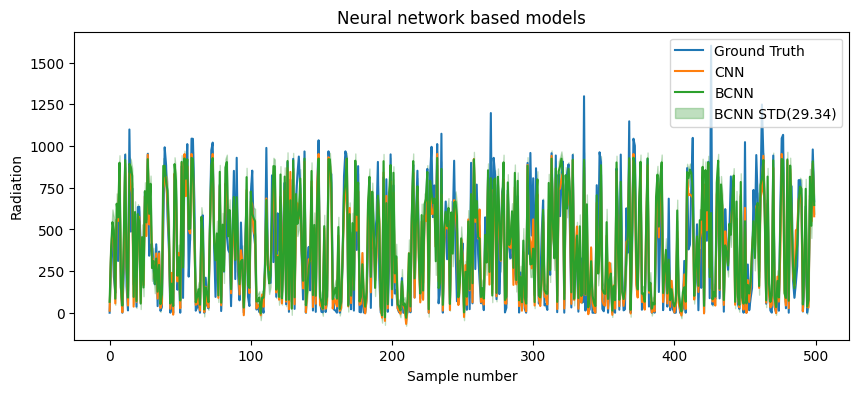

In [39]:
if showPredictionPlots:
    amountOfSamplesForPlot = 500;

    # round(x,2) did not work
    meanOfSTD = int(Bneuralstd.mean()*100) / 100;
    
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], Ytest[0:amountOfSamplesForPlot], label="Ground Truth")
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], neuralRadiationPredictions[0:amountOfSamplesForPlot], label="CNN", alpha = 1)
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], BneuralRadiationPredictions[0:amountOfSamplesForPlot], label="BCNN", alpha = 1)
    plt.fill_between(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], np.ravel(BneuralRadiationPredictions[0:amountOfSamplesForPlot]- Bneuralstd[0:amountOfSamplesForPlot]), np.ravel(BneuralRadiationPredictions[0:amountOfSamplesForPlot] + Bneuralstd[0:amountOfSamplesForPlot]), color='green', alpha=.25, label=f"BCNN STD({meanOfSTD})")
    
    plt.legend(loc='upper right')
    plt.title("Neural network based models")
    plt.xlabel("Sample number")
    plt.ylabel("Radiation")



## Extra models

### KNN Regressor

In [40]:
knnModel = KNeighborsRegressor();

knnModel.fit(XtrainScaled, YtrainScaled)

knnRadiationPredictions = scalerY.inverse_transform(knnModel.predict(XtestScaled).reshape(-1,1))
knnRadiationPredictions = np.pad(knnRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, knnRadiationPredictions);

╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               53.8864 │              13031.6 │   0.871832 │ 1.41245 │      1120.4 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


### SVR

C:\Users\Tycho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


╒═══════════════════════╤══════════════════════╤════════════╤═════════╤═════════════╕
│   Mean Absolute Error │   Mean Squared Error │   R2 Score │    MAPE │   Max Error │
╞═══════════════════════╪══════════════════════╪════════════╪═════════╪═════════════╡
│               47.6586 │              10511.3 │    0.89662 │ 1.81685 │     990.917 │
╘═══════════════════════╧══════════════════════╧════════════╧═════════╧═════════════╛


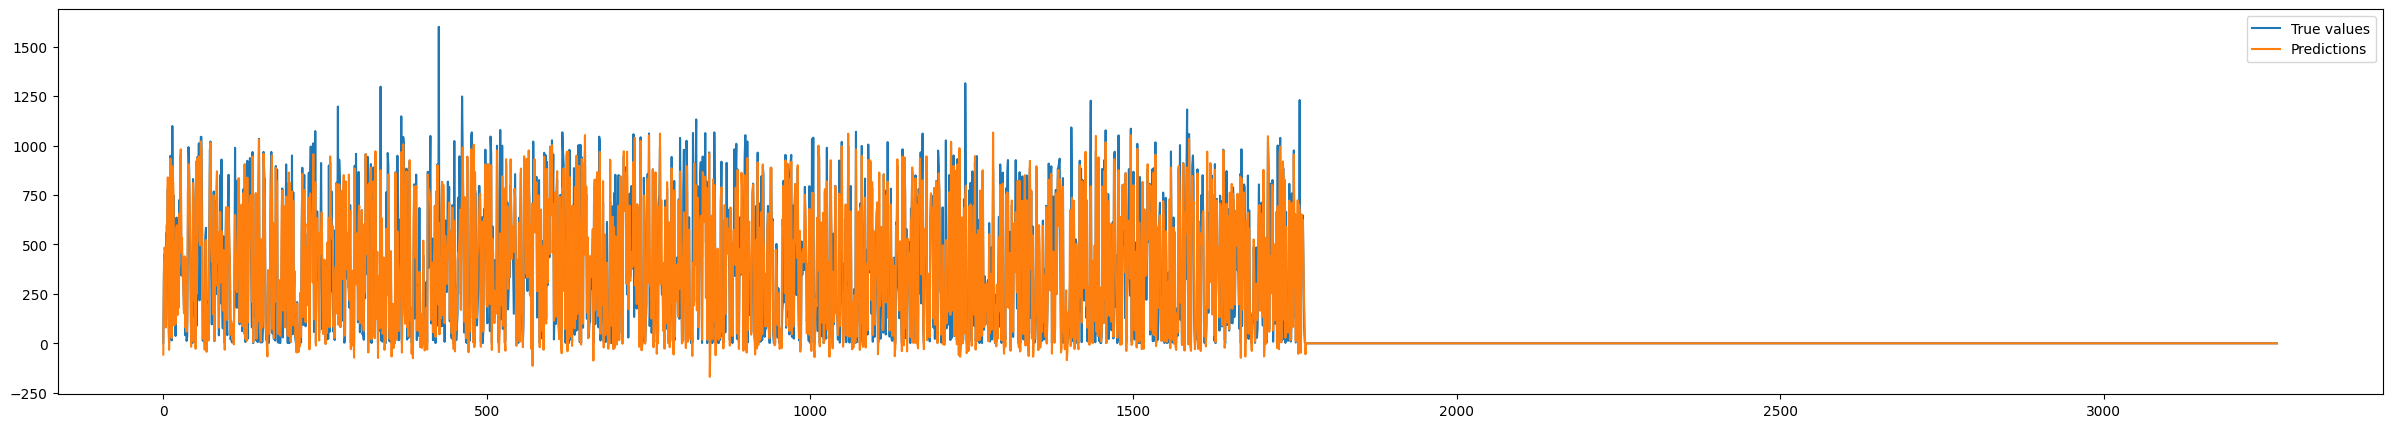

In [41]:
svrModel = SVR(kernel='rbf');
svrModel.fit(XtrainScaled, YtrainScaled); 


svrRadiationPredictions = scalerY.inverse_transform(svrModel.predict(XtestScaled).reshape(-1,1))
svrRadiationPredictions = np.pad(svrRadiationPredictions, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, svrRadiationPredictions)
plotPrediction(Ytest, svrRadiationPredictions)

### RVR

Due to extremely long computation times, RVR is not tested (yet)

In [42]:
# rvrModel = EMRVR(kernel='rbf', verbose=True);

# rvrModel.fit(XtrainScaled, YtrainScaled); 
# rvrRadiationPredictions = rvrModel.predict(XtestScaled);
# printTestMetrics(Ytest, scalerY.inverse_transform(svrRadiationPredictions))

### Gaussion Process Regressor

In [43]:
gprModel = GaussianProcessRegressor();

gprModel.fit(XtrainScaled, YtrainScaled);

KeyboardInterrupt: 

In [ ]:

predGPR, stdGPR = gprModel.predict(XtestScaled, return_std=True)
predGPR = scalerY.inverse_transform(predGPR.reshape(-1,1))
stdGPR = scalerY.inverse_transform(stdGPR.reshape(-1,1))

predGPR = np.pad(predGPR, [(0, padLength), (0,0)], 'constant', constant_values=0);


printTestMetrics(Ytest, predGPR)

In [ ]:
if showPredictionPlots:
    plt.figure(figsize=(10,4))
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], Ytest[0:amountOfSamplesForPlot], label="Ground Truth")
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], svrRadiationPredictions[0:amountOfSamplesForPlot], label="SVR", alpha = 1)
    plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], knnRadiationPredictions[0:amountOfSamplesForPlot], label="KNN", alpha = 1)
    # plt.plot(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], predGPR[0:amountOfSamplesForPlot], label="GPR", alpha = 1, color="darkred")
    # plt.fill_between(np.arange(0, len(Ytest))[0:amountOfSamplesForPlot], np.ravel(predGPR[0:amountOfSamplesForPlot]-stdGPR[0:amountOfSamplesForPlot]), np.ravel(predGPR[0:amountOfSamplesForPlot]+stdGPR[0:amountOfSamplesForPlot]), alpha = 0.2, color="darkred")
    plt.legend(loc="upper right")
    # np.arange(0, len(Ytest))
    plt.title("Remaining models")
    plt.xlabel("Sample number")
    plt.ylabel("Radiation")

# Comparison

The table below is too large to print at once, thus mulitple table will be printed


In [ ]:
# table = [];
# tableColumns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'Mean Absolute Percentage Error', 'Max Error']
# table.append(tableColumns)

# # Linear regression
# table.append(["Linear Regression"]+ calcMetrics(Ytest, linRegRadiationPredictions))

# # Ridge regression
# table.append(["Ridge Regression"]+ calcMetrics(Ytest, ridgeRadiationPredictions))

# # Bayesian  Ridge regression
# table.append(["Bayes Ridge Regression"]+ calcMetrics(Ytest, bRidgeRadiationPredictions))

# # Lasso regression
# table.append(["Lasso Regression"]+ calcMetrics(Ytest, lassoRadiationPredictions))

# # KNN regression
# table.append(["KNN Regression"]+ calcMetrics(Ytest, knnRadiationPredictions))

# # SVR
# table.append(["SVR"]+ calcMetrics(Ytest, svrRadiationPredictions))

# # Decision tree
# table.append(["Decision Tree"]+calcMetrics(Ytest, decTreeRadiationPredictions))

# # Random Forest
# table.append(["Random Forest"]+calcMetrics(Ytest, rndForestRadiationPredictions))

# # Extra Trees
# table.append(["Extra Trees"]+calcMetrics(Ytest, xTreeRadiationPredictions))

# # Neural Net
# table.append(["Neural net"]+ calcMetrics(Ytest, neuralRadiationPredictions))

# # Neural Net Dropout
# table.append(["Neural net dropout"]+ calcMetrics(Ytest, BneuralRadiationPredictions))

# # Gaussian Process Regressor
# table.append(["Gaussian Process Regressor"]+ calcMetrics(Ytest, predGPR))

# # Bayesian Regressor
# table.append(["Bayesian Regressor"]+ calcMetrics(Ytest, predBReg))

# # Empirical Bayesian Regressor
# table.append(["Emp Bayesian Regressor"]+ calcMetrics(Ytest, predBEmpReg))

# # EM  Regressor
# table.append(["EM"]+ calcMetrics(Ytest, predEM))

# # VB Regressor
# table.append(["VB"]+ calcMetrics(Ytest, predVB))

# print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

### Linear Models

In [44]:
table = [];
tableColumns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'Mean Absolute Percentage Error', 'Max Error']
table.append(tableColumns)

# Linear regression
table.append(["Linear Regression"]+ calcMetrics(Ytest, linRegRadiationPredictions))

# Ridge regression
table.append(["Ridge Regression"]+ calcMetrics(Ytest, ridgeRadiationPredictions))

# Bayesian  Ridge regression
table.append(["Bayes Ridge Regression"]+ calcMetrics(Ytest, bRidgeRadiationPredictions))

# Lasso regression
table.append(["Lasso Regression"]+ calcMetrics(Ytest, lassoRadiationPredictions))

# Bayesian Regressor
table.append(["Bayesian Regressor"]+ calcMetrics(Ytest, predBReg))

# Empirical Bayesian Regressor
table.append(["Emp Bayesian Regressor"]+ calcMetrics(Ytest, predBEmpReg))

# EM  Regressor
table.append(["EM"]+ calcMetrics(Ytest, predEM))

# VB Regressor
table.append(["VB"]+ calcMetrics(Ytest, predVB))

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════╤═══════════════════════╤══════════════════════╤════════════╤══════════════════════════════════╤═════════════╕
│ Model                  │   Mean Absolute Error │   Mean Squared Error │   R2 Score │   Mean Absolute Percentage Error │   Max Error │
╞════════════════════════╪═══════════════════════╪══════════════════════╪════════════╪══════════════════════════════════╪═════════════╡
│ Linear Regression      │               96.0409 │              26613.9 │   0.738249 │                          6.45257 │     975.686 │
├────────────────────────┼───────────────────────┼──────────────────────┼────────────┼──────────────────────────────────┼─────────────┤
│ Ridge Regression       │               96.1235 │              26636.6 │   0.738026 │                          6.4749  │     977.698 │
├────────────────────────┼───────────────────────┼──────────────────────┼────────────┼──────────────────────────────────┼─────────────┤
│ Bayes Ridge Regression │               96.1392

In [45]:
generateTex(table)


  \\ \hline 
 Linear Regression & 96.04 & 26613.93 & 0.74 & 6.45 & 975.69  \\ \hline 
 Ridge Regression & 96.12 & 26636.56 & 0.74 & 6.47 & 977.7  \\ \hline 
 Bayes Ridge Regression & 96.14 & 26637.4 & 0.74 & 6.48 & 978.45  \\ \hline 
 Lasso Regression & 108.9 & 32428.78 & 0.68 & 8.61 & 1014.29  \\ \hline 
 Bayesian Regressor & 96.12 & 26636.56 & 0.74 & 6.47 & 977.7  \\ \hline 
 Emp Bayesian Regressor & 96.14 & 26637.28 & 0.74 & 6.48 & 978.5  \\ \hline 
 EM & 96.14 & 26637.25 & 0.74 & 6.48 & 978.51  \\ \hline 
 VB & 96.14 & 26636.73 & 0.74 & 6.47 & 979.75  \\ \hline 
 


### Tree based Models

╒═══════════════╤═══════════════════════╤══════════════════════╤════════════╤══════════════════════════════════╤═════════════╕
│ Model         │   Mean Absolute Error │   Mean Squared Error │   R2 Score │   Mean Absolute Percentage Error │   Max Error │
╞═══════════════╪═══════════════════════╪══════════════════════╪════════════╪══════════════════════════════════╪═════════════╡
│ Decision Tree │               37.4685 │             10096    │   0.900705 │                         0.406181 │     942.617 │
├───────────────┼───────────────────────┼──────────────────────┼────────────┼──────────────────────────────────┼─────────────┤
│ Random Forest │               30.3322 │              6315.15 │   0.93789  │                         0.186947 │     889.644 │
├───────────────┼───────────────────────┼──────────────────────┼────────────┼──────────────────────────────────┼─────────────┤
│ Extra Trees   │               30.5618 │              6365.86 │   0.937391 │                         0.226249 

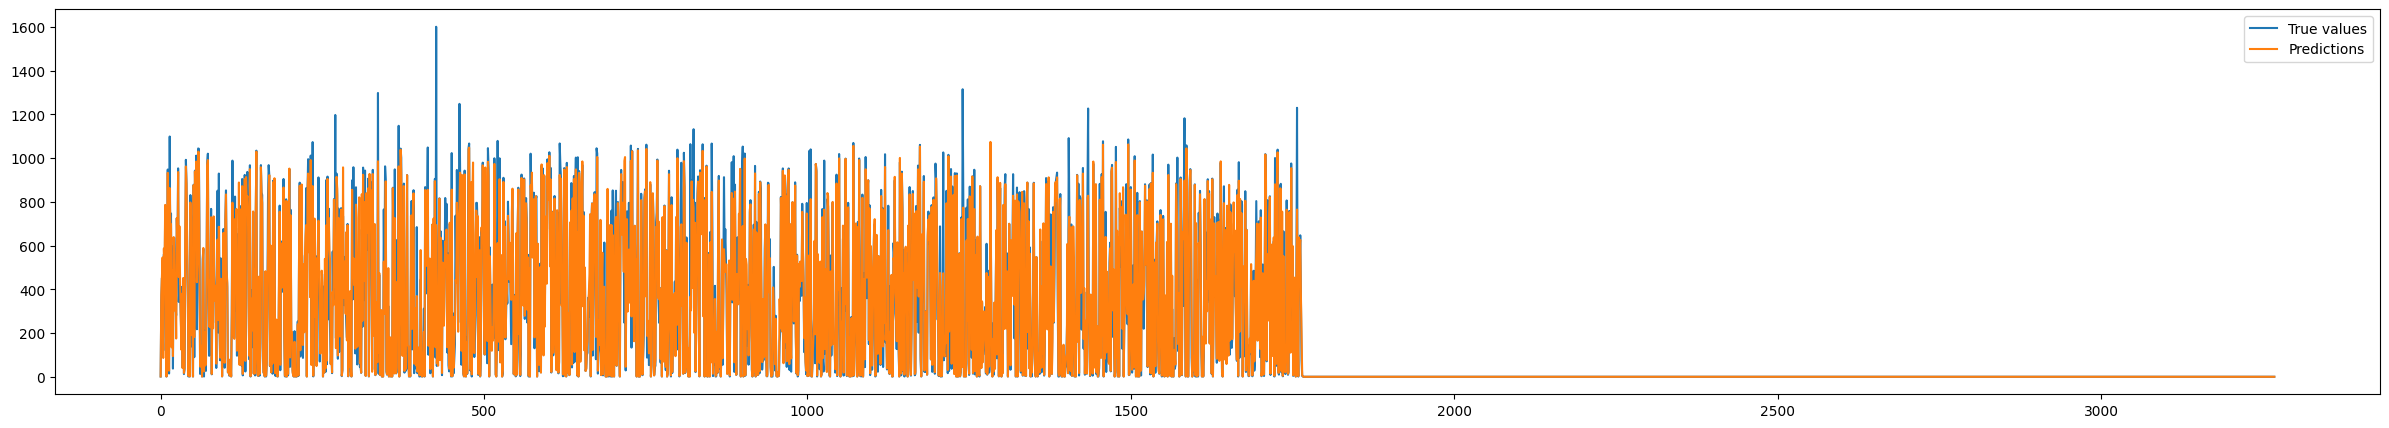

In [46]:
table = [];
tableColumns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'Mean Absolute Percentage Error', 'Max Error']
table.append(tableColumns)

# Decision tree
table.append(["Decision Tree"]+calcMetrics(Ytest, decTreeRadiationPredictions))

# Random Forest
table.append(["Random Forest"]+calcMetrics(Ytest, rndForestRadiationPredictions))

# Extra Trees
table.append(["Extra Trees"]+calcMetrics(Ytest, xTreeRadiationPredictions))

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

plotPrediction(Ytest, xTreeRadiationPredictions)

In [47]:
generateTex(table)

  \\ \hline 
 Decision Tree & 37.47 & 10095.99 & 0.9 & 0.41 & 942.62  \\ \hline 
 Random Forest & 30.33 & 6315.15 & 0.94 & 0.19 & 889.64  \\ \hline 
 Extra Trees & 30.56 & 6365.86 & 0.94 & 0.23 & 907.29  \\ \hline 
 


## Neurals

In [48]:
table = [];
tableColumns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'Mean Absolute Percentage Error', 'Max Error']
table.append(tableColumns)

# Neural Net
table.append(["Neural net"]+ calcMetrics(Ytest, neuralRadiationPredictions))

# Neural Net Dropout
table.append(["Neural net dropout"]+ calcMetrics(Ytest, BneuralRadiationPredictions))

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════╤═══════════════════════╤══════════════════════╤════════════╤══════════════════════════════════╤═════════════╕
│ Model              │   Mean Absolute Error │   Mean Squared Error │   R2 Score │   Mean Absolute Percentage Error │   Max Error │
╞════════════════════╪═══════════════════════╪══════════════════════╪════════════╪══════════════════════════════════╪═════════════╡
│ Neural net         │               49.8535 │              10723.2 │   0.894536 │                          1.29392 │     1102.74 │
├────────────────────┼───────────────────────┼──────────────────────┼────────────┼──────────────────────────────────┼─────────────┤
│ Neural net dropout │               57.5641 │              12792.2 │   0.874187 │                          2.6133  │     1002.5  │
╘════════════════════╧═══════════════════════╧══════════════════════╧════════════╧══════════════════════════════════╧═════════════╛


In [49]:
generateTex(table)

  \\ \hline 
 Neural net & 49.85 & 10723.22 & 0.89 & 1.29 & 1102.74  \\ \hline 
 Neural net dropout & 57.56 & 12792.22 & 0.87 & 2.61 & 1002.5  \\ \hline 
 


## Extra models

In [50]:
table = [];
tableColumns = ['Model', 'Mean Absolute Error', 'Mean Squared Error', 'R2 Score', 'Mean Absolute Percentage Error', 'Max Error']
table.append(tableColumns)

# SVR
table.append(["SVR"]+ calcMetrics(Ytest, svrRadiationPredictions))

# KNN regression
table.append(["KNN Regression"]+ calcMetrics(Ytest, knnRadiationPredictions))


# Gaussian Process Regressor
table.append(["Gaussian Process Regressor"]+ calcMetrics(Ytest, predGPR))


NameError: name 'predGPR' is not defined

In [ ]:
generateTex(table)

# Data Analysis
This final chapter consits of some plots and calculations which help in the arguments of the discussion, or helped clarifying structures in the data.

<Axes: xlabel='Temperature', ylabel='Radiation'>

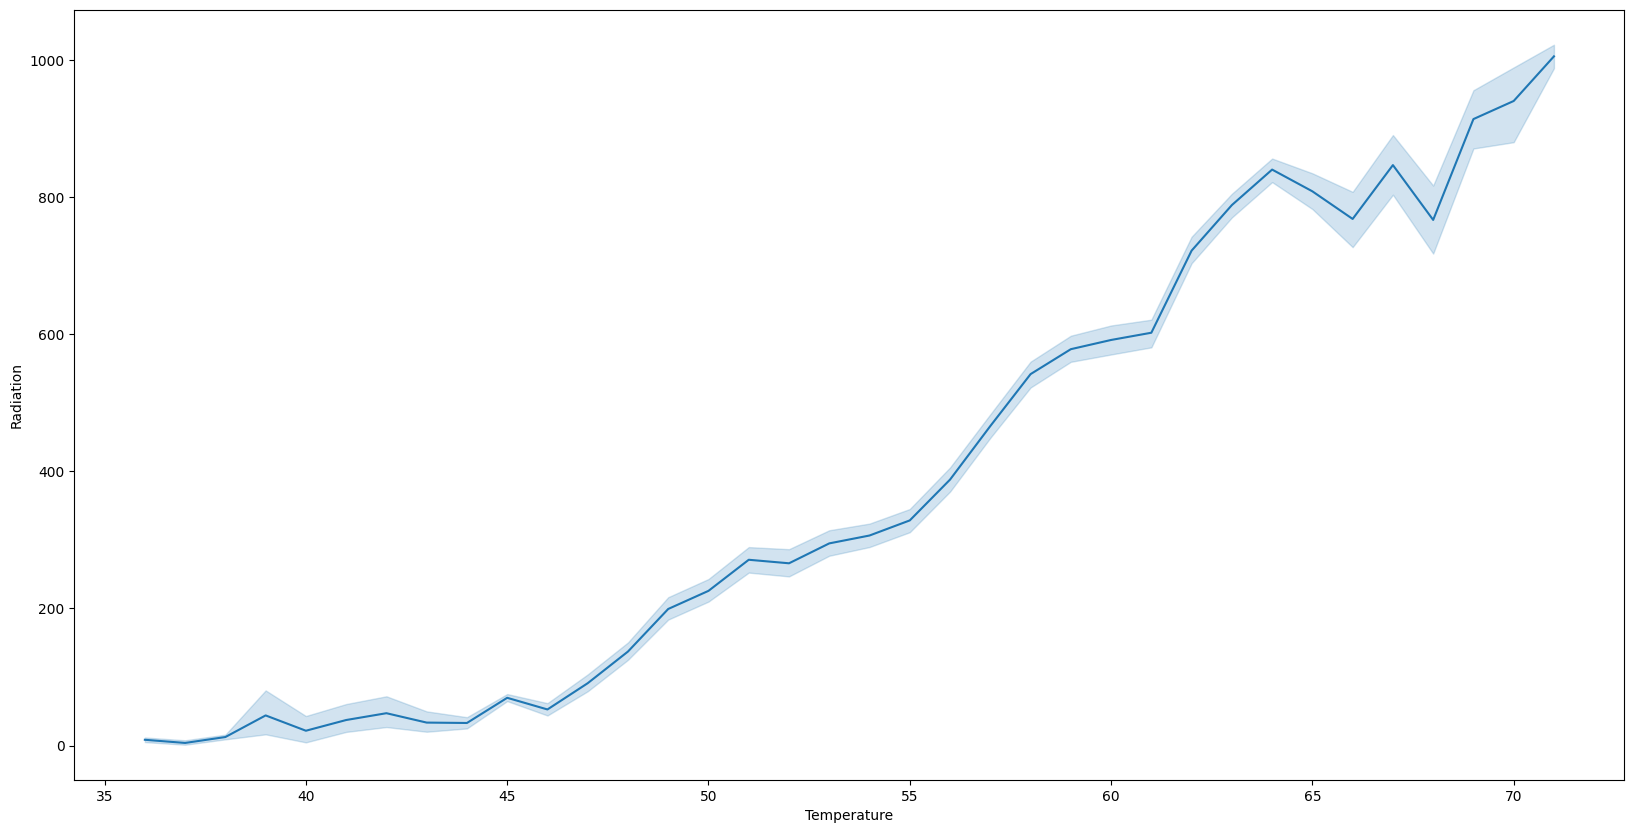

In [51]:
# Temperature against radiation plit
plt.figure(figsize=(20,10))
seaborn.lineplot(x=data["Temperature"], y=data["Radiation"])


### Radiation and temperature per hour

In [52]:
## Average radiation over hours
radiationPerHour = data.groupby([pd.Grouper(key='Hour')])['Radiation']

minRadiationPerHour = radiationPerHour.min()
maxRadiationPerHour = radiationPerHour.max()
meanRadiationPerHour = radiationPerHour.mean()
stdRadiationPerHour = radiationPerHour.std()


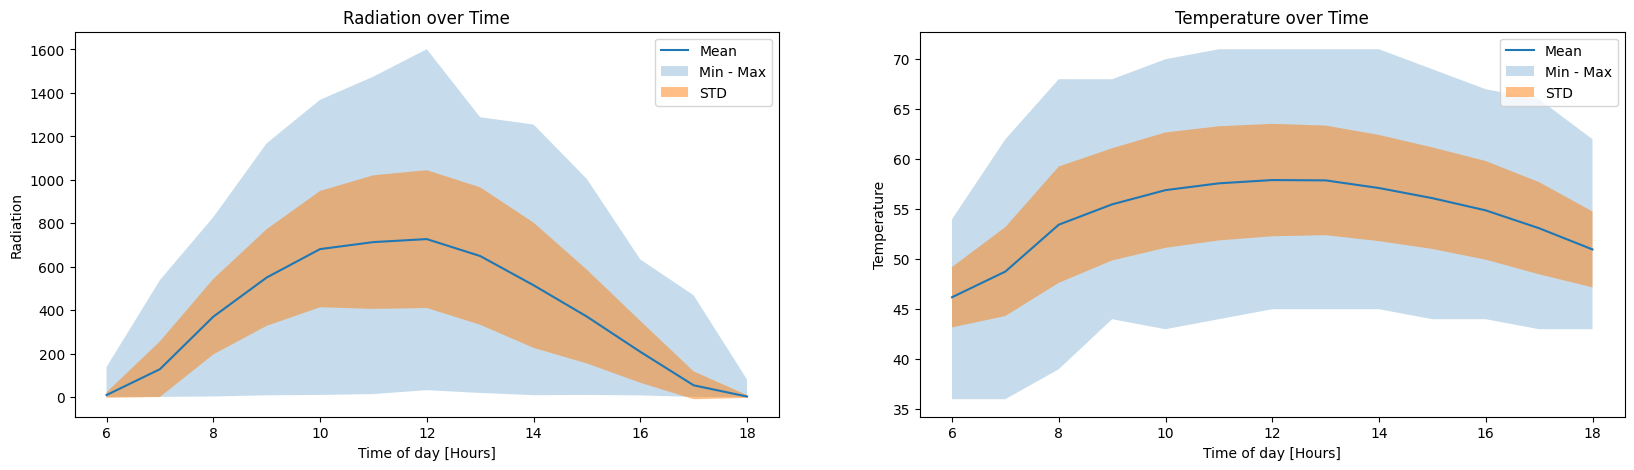

In [53]:
## Average temperature over hours
temperaturePerHour = data.groupby([pd.Grouper(key='Hour')])['Temperature']

minTemperaturePerHour = temperaturePerHour.min()
maxTemperaturePerHour = temperaturePerHour.max()
meanTemperaturePerHour = temperaturePerHour.mean()
stdTemperaturePerHour = temperaturePerHour.std()

timeAxis = minTemperaturePerHour.index;
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(timeAxis, meanRadiationPerHour, label = "Mean")
plt.fill_between(timeAxis, minRadiationPerHour, maxRadiationPerHour, alpha=0.25, label="Min - Max")
plt.fill_between(timeAxis, meanRadiationPerHour-stdRadiationPerHour, meanRadiationPerHour+stdRadiationPerHour, alpha=0.5, label="STD")
plt.legend()
plt.title("Radiation over Time")
plt.xlabel("Time of day [Hours]")
plt.ylabel("Radiation")

plt.subplot(1,2,2)
plt.plot(timeAxis, meanTemperaturePerHour, label = "Mean")
plt.fill_between(timeAxis, minTemperaturePerHour, maxTemperaturePerHour, alpha=0.25, label="Min - Max")
plt.fill_between(timeAxis, meanTemperaturePerHour-stdTemperaturePerHour, meanTemperaturePerHour+stdTemperaturePerHour, alpha=0.5, label="STD")
plt.title("Temperature over Time")
plt.xlabel("Time of day [Hours]")
plt.ylabel("Temperature")

plt.legend()

Text(0, 0.5, 'Temperature')

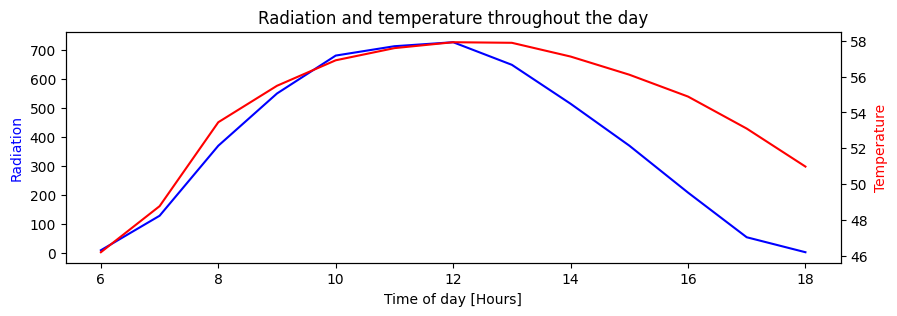

In [54]:
plt.figure(figsize=(10,3))
plt.plot(meanRadiationPerHour, color='blue')
plt.title("Radiation and temperature throughout the day")
plt.ylabel("Radiation", color='blue')
plt.xlabel("Time of day [Hours]")
plt.twinx()
plt.plot(meanTemperaturePerHour, color='red')
plt.ylabel("Temperature", color='red')

    

In [55]:
LinearMetrics = calcMetrics(Ytest, linRegRadiationPredictions)
RidgeMetrics = calcMetrics(Ytest, ridgeRadiationPredictions)

BRegMetrics = calcMetrics(Ytest, predBReg)
EMMetrics = calcMetrics(Ytest, predEM)
VBMetrics = calcMetrics(Ytest, predVB)

DecTreeMetrics = calcMetrics(Ytest, decTreeRadiationPredictions)
RNFMetrics = calcMetrics(Ytest, rndForestRadiationPredictions)
XTreeMetrics = calcMetrics(Ytest, xTreeRadiationPredictions)

CNNMetrics = calcMetrics(Ytest, neuralRadiationPredictions)
BCNNMetrics =  calcMetrics(Ytest, BneuralRadiationPredictions)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(1, 0.0, '0'),
  Text(1, 200.0, '200'),
  Text(1, 400.0, '400'),
  Text(1, 600.0, '600'),
  Text(1, 800.0, '800'),
  Text(1, 1000.0, '1000'),
  Text(1, 1200.0, '1200')])

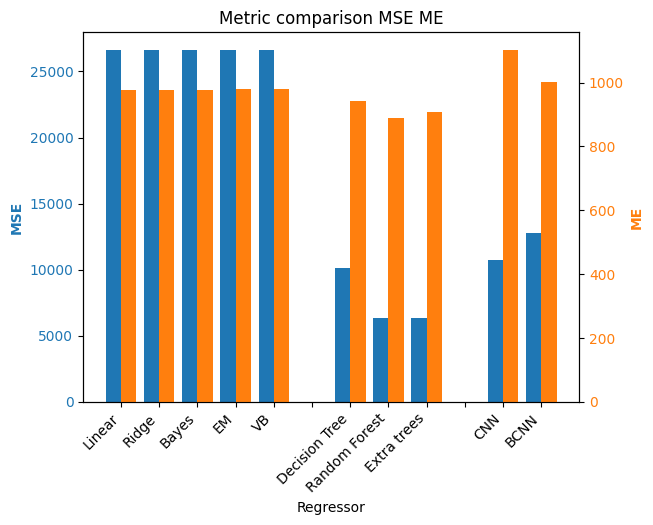

In [78]:
plt.figure()

XAXIS = ['Linear', 'Ridge', 'Bayes', 'EM', 'VB', '', 'Decision Tree', 'Random Forest', 'Extra trees', ' ', 'CNN', 'BCNN']
YAXIS1 = [LinearMetrics[1], RidgeMetrics[1], BRegMetrics[1], EMMetrics[1], VBMetrics[1], 0, DecTreeMetrics[1], RNFMetrics[1], XTreeMetrics[1], 0, CNNMetrics[1], BCNNMetrics[1] ]
YAXIS2 = [LinearMetrics[4], RidgeMetrics[4], BRegMetrics[4], EMMetrics[4], VBMetrics[4], 0, DecTreeMetrics[4], RNFMetrics[4], XTreeMetrics[4], 0, CNNMetrics[4], BCNNMetrics[4] ]
plt.bar(np.arange(len(XAXIS)), YAXIS1, width=0.4, color="#1f77b4")
plt.ylabel("MSE", color="#1f77b4", fontweight="bold")
plt.xticks(np.arange(len(XAXIS))+0.2, ('Linear', 'Ridge', 'Bayes', 'EM', 'VB', '', 'Decision Tree', 'Random Forest', 'Extra trees', ' ', 'CNN', 'BCNN'), rotation=45,ha='right');
plt.yticks(color="#1f77b4")
plt.xlabel("Regressor")
plt.title("Metric comparison MSE ME")

plt.twinx()
plt.bar(np.arange(len(XAXIS))+0.4, YAXIS2, color='#ff7f0e', width=0.4)
plt.ylabel("ME", color="#ff7f0e", fontweight="bold")
plt.yticks(color="#ff7f0e")
